# Implementacija  tagera za srpski jezik koriscenjem NLTK biblioteke


## Nikola Vukotic 1401
## Sofija Petrovic 1115

In [1]:
def reverse_corpus(filename):
 
    with open(filename,  encoding= 'utf8') as f:
        words = f.readlines()
    
    # then reverse the split string list and join using space
    reversed_corpus = ''.join(reversed(words))
 
    # finally return the joined string
    return reversed_corpus

#rev = reverse_corpus('/home/nikola/Desktop/NLP Nikola/srWaC1.1.06/srWaC1.1.06-o11.txt')

#with open('/home/nikola/Desktop/NLP Nikola/srWaC1.1.06/srWaC1.1.06-o11_reversed.txt', 'a', encoding = "utf8") as f:
#    f.write(rev)

In [2]:
import os

class CorpusProcessor:
	def __init__(self, corpus_name, corpus_dir_path, sentence_count, encoding):
		self.corpus_name = corpus_name
		self.corpus_dir_path = corpus_dir_path
		self.sentence_count = sentence_count
		self.encoding = encoding

	def count_lines(self, file_path):
		count = 0
		with open(file_path, "r", encoding=self.encoding) as file:
			for line in file.readlines():
				count += 1
		return count

	def split(self, transformed_filename, tansformed_file_line_count, splitting_factor = 0.8):
		splitting_index = int(tansformed_file_line_count * splitting_factor)

		training_lines = []
		test_lines = []

		train_filename = self.corpus_name + "_transformed_train.txt"
		test_filename = self.corpus_name + "_transformed_test.txt"

		transformed_corpus = os.path.join(self.corpus_dir_path, transformed_filename)
		train_filepath = os.path.join(self.corpus_dir_path, train_filename)
		test_filepath = os.path.join(self.corpus_dir_path, test_filename)

		with open(transformed_corpus, "r", encoding=self.encoding) as file, open(train_filepath, "a+", encoding=self.encoding) as train_file, open(test_filepath, "a+", encoding=self.encoding) as test_file:
			for i, line in enumerate(file.readlines()):
				if (i <= splitting_index):
					training_lines.append(line)
				else:
					test_lines.append(line)


			train_file.writelines(training_lines)
			test_file.writelines(test_lines)

class SrWaCCorpusProcessor(CorpusProcessor):
	def __init__(self, corpus_name, corpus_dir_path, original_corpus_filename, sen_count = 0):
		if (sen_count == 0):
			sen_count = self._get_sentence_count(corpus_dir_path, original_corpus_filename)

		super().__init__(corpus_name, corpus_dir_path, sen_count, "utf-8")
		self.original_corpus_filename = original_corpus_filename
	
	def _get_sentence_count(self, directory, filename):
		sentence_count = 0
		path = os.path.join(directory, filename)
		with open(path, "r", encoding="utf-8") as file:
			for line in file:
				sentence_count += 1

		return sentence_count
	def is_punctuation(self, word, tag):
		if ((tag == 'Z') and ((word == '.') or (word == '?') or (word == '!'))):
			return True
		else:
			return False

	def transform_sentence(self, sentence):
		transformed_sentence = ""
		num_of_parts = len(sentence)
		for i, word_tag_tuple in enumerate(sentence):
			word = word_tag_tuple[0]
			tag = word_tag_tuple[1].upper()

			transformed_sentence += word + "/" + tag
			if i < num_of_parts:
				transformed_sentence += " "
		
		return transformed_sentence

	def write_sents_to_file(self, sentences, file_name):
		with open(file_name, "a+", encoding="utf-8") as file:
			for sentence in sentences:
				transformed_sentence = self.transform_sentence(sentence)
				file.write(transformed_sentence + "\n\n")

	def transform_corpus(self):
		transformed_corpus_filename = self.original_corpus_filename[:-4]
		transformed_corpus_filename += "_transformed.txt"
		transformed_corpus_filepath = os.path.join(self.corpus_dir_path, transformed_corpus_filename)

		sents_buffer = []
		current_sent = []
		sents_buffer_count = 0
		line_count = self.sentence_count
		num_of_sentences = 0

		full_path = os.path.join(self.corpus_dir_path, self.original_corpus_filename)
		with open(full_path, encoding="utf-8") as corpus_file:
			for i, line in enumerate(corpus_file):
				line_parts = line.rstrip('\n').split('|')
				word = line_parts[0]
				tag = line_parts[1]
				tagged_word_tuple = tuple((word, tag))
				
				if self.is_punctuation(word, tag):
					current_sent.append(tagged_word_tuple)
					sents_buffer.append(current_sent)
					sents_buffer_count += 1
					num_of_sentences += 1

					if (sents_buffer_count >= 1000):
						# num_of_sentences += sents_buffer_count
						self.write_sents_to_file(sents_buffer, transformed_corpus_filepath)

						sents_buffer = []
						sents_buffer_count = 0
					
					current_sent = []
				else:
					current_sent.append(tagged_word_tuple)

		if (len(sents_buffer) > 0):
			self.write_sents_to_file(sents_buffer, transformed_corpus_filepath)

		transformed_file_line_count = self.count_lines(transformed_corpus_filepath)	
		print("srWaC corpus. Number of sentences: " + str(num_of_sentences))
		return transformed_corpus_filename, transformed_file_line_count

#processor = SrWaCCorpusProcessor("srWaC", 
#	"/home/nikola/Desktop/NLP Nikola/srWaC1.1.06/", 
#	"srWaC1.1.06-o11.txt")

#transformed_name, line_count = processor.transform_corpus()
#processor.split(transformed_name, line_count, 0.5)




In [3]:
import nltk
import pickle
import dill
from nltk.corpus.reader import TaggedCorpusReader
from nltk.tag import UnigramTagger
from nltk.tag import BigramTagger
from nltk.tag import TrigramTagger
from nltk.tag import DefaultTagger

class Trainer:
	def __init__(self, corpus_root, training_file, corpus_name, tagger_name, models_dir, backoff=None):
		self.tagger_name = tagger_name
		self.corpus_name = corpus_name
		self.models_dir = models_dir
		if (backoff != None):
			print("Loading backoff tagger...")
			self.backoff = self.load_tagger(backoff)
		else:
			self.backoff = nltk.DefaultTagger("Nn")
			if (self.corpus_name == "SrpLemKor"):
				self.backoff = nltk.DefaultTagger("N")

		self.encoding = "utf-8"
		
		if (self.corpus_name == "SrpLemKor"):
			loaded_training_sents = self.load_training_sents(corpus_root, training_file)
			self._process_training_sents(loaded_training_sents)
		else:
			tcr = TaggedCorpusReader(corpus_root, training_file, encoding=self.encoding)
			self.training_sents = tcr.tagged_sents()

	def _process_training_sents(self, loaded_training_sents):
		self.training_sents = []
		for i, sent in enumerate(loaded_training_sents):
			training_sentence = []
			for i, tup in enumerate(sent):
				word, tag = tup

				# ignore these cases
				if (word == None or len(word) == 0):
					continue

				training_sentence.append(tup)
			self.training_sents.append(training_sentence)
	
	def load_training_sents(self, corpus_root, training_file):
		tcr = TaggedCorpusReader(corpus_root, training_file, encoding=self.encoding)
		training_sents = tcr.tagged_sents()
		return training_sents

	def backoff_tagger(self, train_sentences, tagger_classes, backoff):
		for cls in tagger_classes:
				backoff = cls(train_sentences, backoff=backoff)
		return backoff    
    
	def train(self):
		print("Training the tagger...")

		tagger = None
		if (self.tagger_name == 'unigram-tagger'):
			tagger = nltk.UnigramTagger(self.training_sents)
		if (self.tagger_name == 'bigram-tagger'):
			tagger = nltk.BigramTagger(self.training_sents)
		if (self.tagger_name == 'trigram-tagger'):
			tagger = nltk.TrigramTagger(self.training_sents)
		if (self.tagger_name == 'tnt-tagger'):
			tagger = nltk.tag.tnt.TnT(None, False, 1000, False)
			tagger.train(self.training_sents)
		if (self.tagger_name == 'perceptron-tagger'):
			tagger = nltk.tag.PerceptronTagger(load=False)
			tagger.train(self.training_sents)
		if (self.tagger_name == 'hmm-tagger'):
			trainer = nltk.tag.hmm.HiddenMarkovModelTrainer()
			tagger = trainer.train_supervised(self.training_sents)
		if (self.tagger_name == 'combined-tagger'):
			back_tagger = DefaultTagger('NN')
			classes = [UnigramTagger, BigramTagger, TrigramTagger]
			tagger = self.backoff_tagger(self.training_sents, classes, back_tagger)
            
		return self.save_tagger(tagger)
	
	def save_tagger(self, tagger):
		if tagger == None:
			raise Exception("Tagger is not defined.")

		path = ""
		print("Dumping tagger...")
		if (self.tagger_name == 'hmm-tagger'):
			path = os.path.join(self.models_dir, self.corpus_name + "_" + self.tagger_name + ".dill")
			with open(path, "wb") as file:
				dill.dump(tagger, file)
		else:
			path = os.path.join(self.models_dir, self.corpus_name + "_" + self.tagger_name + ".pickle")
			with open(path, "wb") as file:
				pickle.dump(tagger, file)
				
		return path

	def load_tagger(self, filename):
		if (self.tagger_name == 'hmm-tagger'):
			with open(filename, "rb") as file:
				return dill.load(file)
		else:
			with open(filename, "rb") as file:
				return pickle.load(file)

/usr/lib/python3/dist-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
/usr/lib/python3/dist-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.

## EVALUATOR

In [4]:

from sklearn import metrics as skmetrics
import pandas
import seaborn
import matplotlib.pyplot as plt

labels_srWaC = ['AGA', 'AGD', 'AGG', 'AGI', 'AGL', 'AGN', 'AGV', 
	'APA', 'APD', 'APG', 'API', 'APL', 'APN', 'APV', 
	'ASA', 'ASD', 'ASG', 'ASI', 'ASL', 'ASN', 
	'CC', 'CS', 
	'I', 
	'MC', 'MCA', 'MCD', 'MCG', 'MCI', 'MCL', 'MCN', 
	'MM', 
	'MO', 'MOA', 'MOD', 'MOG', 'MOI', 'MOL', 'MON', 
	'MS', 'MSI', 'MSL', 'MSN', 
	'NA', 'ND', 'NG', 'NI', 'NL', 'NN', 'NV', 
	'PNA', 'PND', 'PNG', 'PNI', 'PNL', 'PNN', 
	'PPA', 'PPD', 'PPG', 'PPI', 'PPL', 'PPN', 'PPV', 
	'PXA', 'PXD', 'PXG', 'PXI', 'PXL', 
	'QO', 'QQ', 'QR', 'QZ', 
	'RG', 'RR', 'RS', 
	'SA', 'SD', 'SG', 'SI', 'SL', 
	'VAA', 'VAE', 'VAM', 'VAN', 'VAP', 'VAR', 
	'VMA', 'VME', 'VMF', 'VMM', 'VMN', 'VMP', 'VMR', 
	'X', 'XF', 'Y', 'Z', 'Prazno']

class Evaluator:
	def __init__(self, model_file, model_name, corpus_root, train_sents_file, test_sents_file, load_model=False, is_hmm=False):
		self.tagger = None
		self.model_name = model_name
		self.corpus_root = corpus_root
		self.train_sents_file = train_sents_file
		self.test_sents_file = test_sents_file

		if (load_model):
			print("Loading tagger model...")
			with open(model_file, "rb") as file:
				if (is_hmm):
					print("Loading HMM tagger model.")
					self.tagger = dill.load(file)
				else:
					self.tagger = pickle.load(file)
	
	def evaluate(self):
        
		tagged_tags = "tagged_tags"
		gold_tags = "gold_tags"        
        
		def function(x):
			x = 'Prazno' if x is None else x
			return x
        
		test_taggedCR = TaggedCorpusReader(self.corpus_root, self.test_sents_file)
		test_sents = self.load_test_sents(test_taggedCR)

		sents_without_tags = self.strip_tags(test_sents)
		gold = self.strip_words(test_sents)
		gold = [function(x) for x in list(gold)]
        
		print("Tagger started tagging...")
		test_sents_count = len(sents_without_tags)
		tagger_tagged_sents = []
		for i, test_sent in enumerate(sents_without_tags):
			tagger_tagged_sentence = self.tagger.tag(test_sent)
			tagger_tagged_sents.append(tagger_tagged_sentence)
		print("Tagger finished.")

		tagger_tags = self.strip_words(tagger_tagged_sents)
		tagger_tags = [function(x) for x in list(tagger_tags)]
        
		print("Evaluating...")
		print("Accuracy : ", skmetrics.accuracy_score(gold, tagger_tags))
		print("Creating confusion matrix...")
		self.plot_confusion_matrix(gold, tagger_tags)

	def plot_confusion_matrix(self, gold, tagger_tags):
        
		labels = labels_srWaC
		confusion_matrix = skmetrics.confusion_matrix(gold, tagger_tags, labels=labels)

		df_cm = pandas.DataFrame(confusion_matrix, index = [i for i in labels], columns = [i for i in labels])
		df_cm.index.name = 'Actual'
		df_cm.columns.name = 'Predicted'
		fig, ax = plt.subplots(figsize=(len(labels), len(labels)))
		seaborn.heatmap(df_cm, annot=True, fmt='', ax=ax)
		plt.savefig(self.model_name + ".png")
		# plt.show()

		# print(nltk.metrics.ConfusionMatrix(gold, tagger_tags))

	def strip_tags(self, test_sents):
		print("Stripping tags from test sentences...")
		stripped_test_sents = []
		for sentence in test_sents:
			words = [word for word, _ in sentence]
			stripped_test_sents.append(words)
		
		print("Stripping tags done.")
		return stripped_test_sents

	def strip_tagger_tags(self, test_sents):
		print("Stripping tags from tagged sentences...")
		stripped_test_sents = [word for sentence in test_sents for word, _ in sentence]
		return stripped_test_sents

	def strip_words(self, sents):
		print("Stripping words from sentences...")
		stripped_sents = [tag for sentence in sents for _, tag in sentence]
		print()
		return stripped_sents

	def load_test_sents(self, tagged_corpus_reader):
		print("Loading test sentences...")
		test_sents = tagged_corpus_reader.tagged_sents()
		return test_sents

/home/nikola/.local/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [5]:
srwac_corpus_root = "/home/nikola/Desktop/NLP Nikola/srWaC1.1.06/"
srwac_training_file = "srWaC_transformed_test.txt"
srwac_testing_file = "srWaC_transformed_test.txt"
corpus_name = "srWaC"

### Unigram tagger

######## unigram-tagger #######
Training the tagger...
Dumping tagger...
Loading tagger model...
Loading test sentences...
Stripping tags from test sentences...
Stripping tags done.
Stripping words from sentences...

Tagger started tagging...
Tagger finished.
Stripping words from sentences...

Evaluating...
Accuracy :  0.8842878424870727
Creating confusion matrix...
##############################


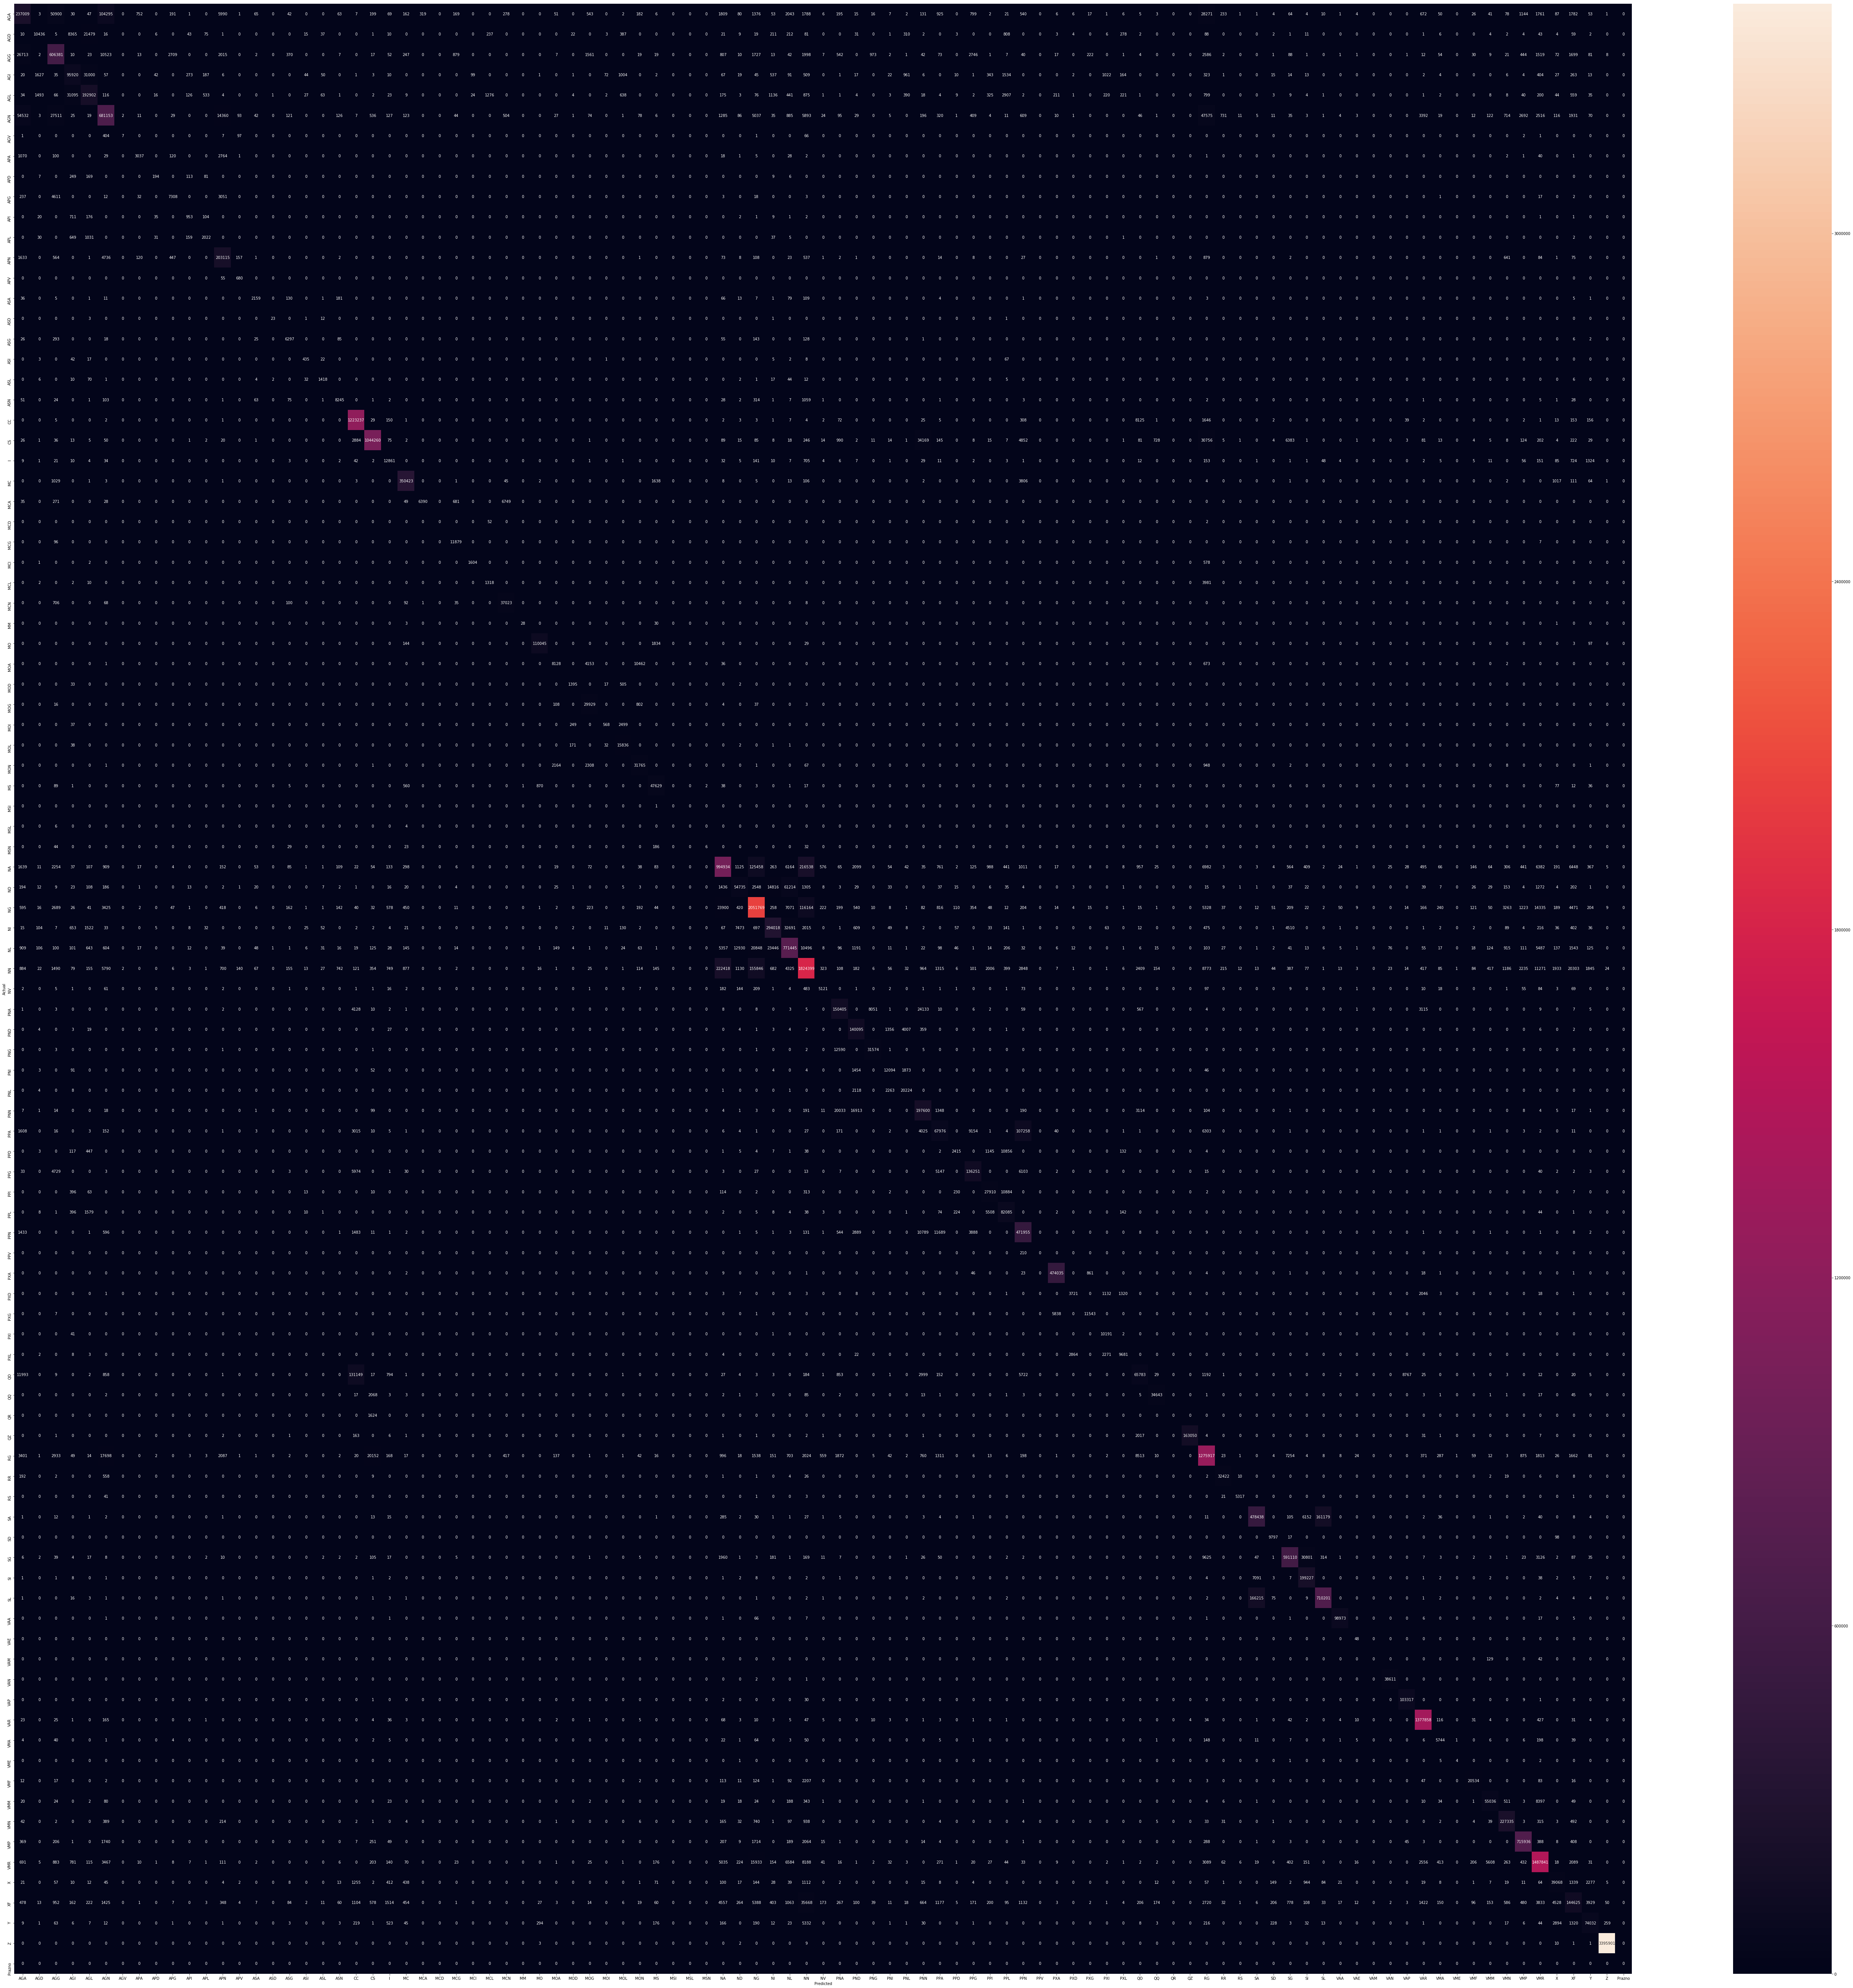

In [9]:
tagger_name = "unigram-tagger"
print("######## {} #######".format(tagger_name))

trainer = Trainer(corpus_root=srwac_corpus_root, 
	training_file=srwac_training_file, 
	corpus_name=corpus_name, 
	tagger_name=tagger_name,
	models_dir="/home/nikola/Desktop/NLP Nikola/Models")

model_path = trainer.train()
model_name = corpus_name + "-" + tagger_name
evaluator = Evaluator(model_path, model_name, srwac_corpus_root, srwac_training_file, srwac_testing_file, True)
evaluator.evaluate()
print("##############################")

### Bigram tagger

######## bigram-tagger #######
Training the tagger...
Dumping tagger...
Loading tagger model...
Loading test sentences...
Stripping tags from test sentences...
Stripping tags done.
Stripping words from sentences...

Tagger started tagging...
Tagger finished.
Stripping words from sentences...

Evaluating...
Accuracy :  0.7403280339827918
Creating confusion matrix...
##############################


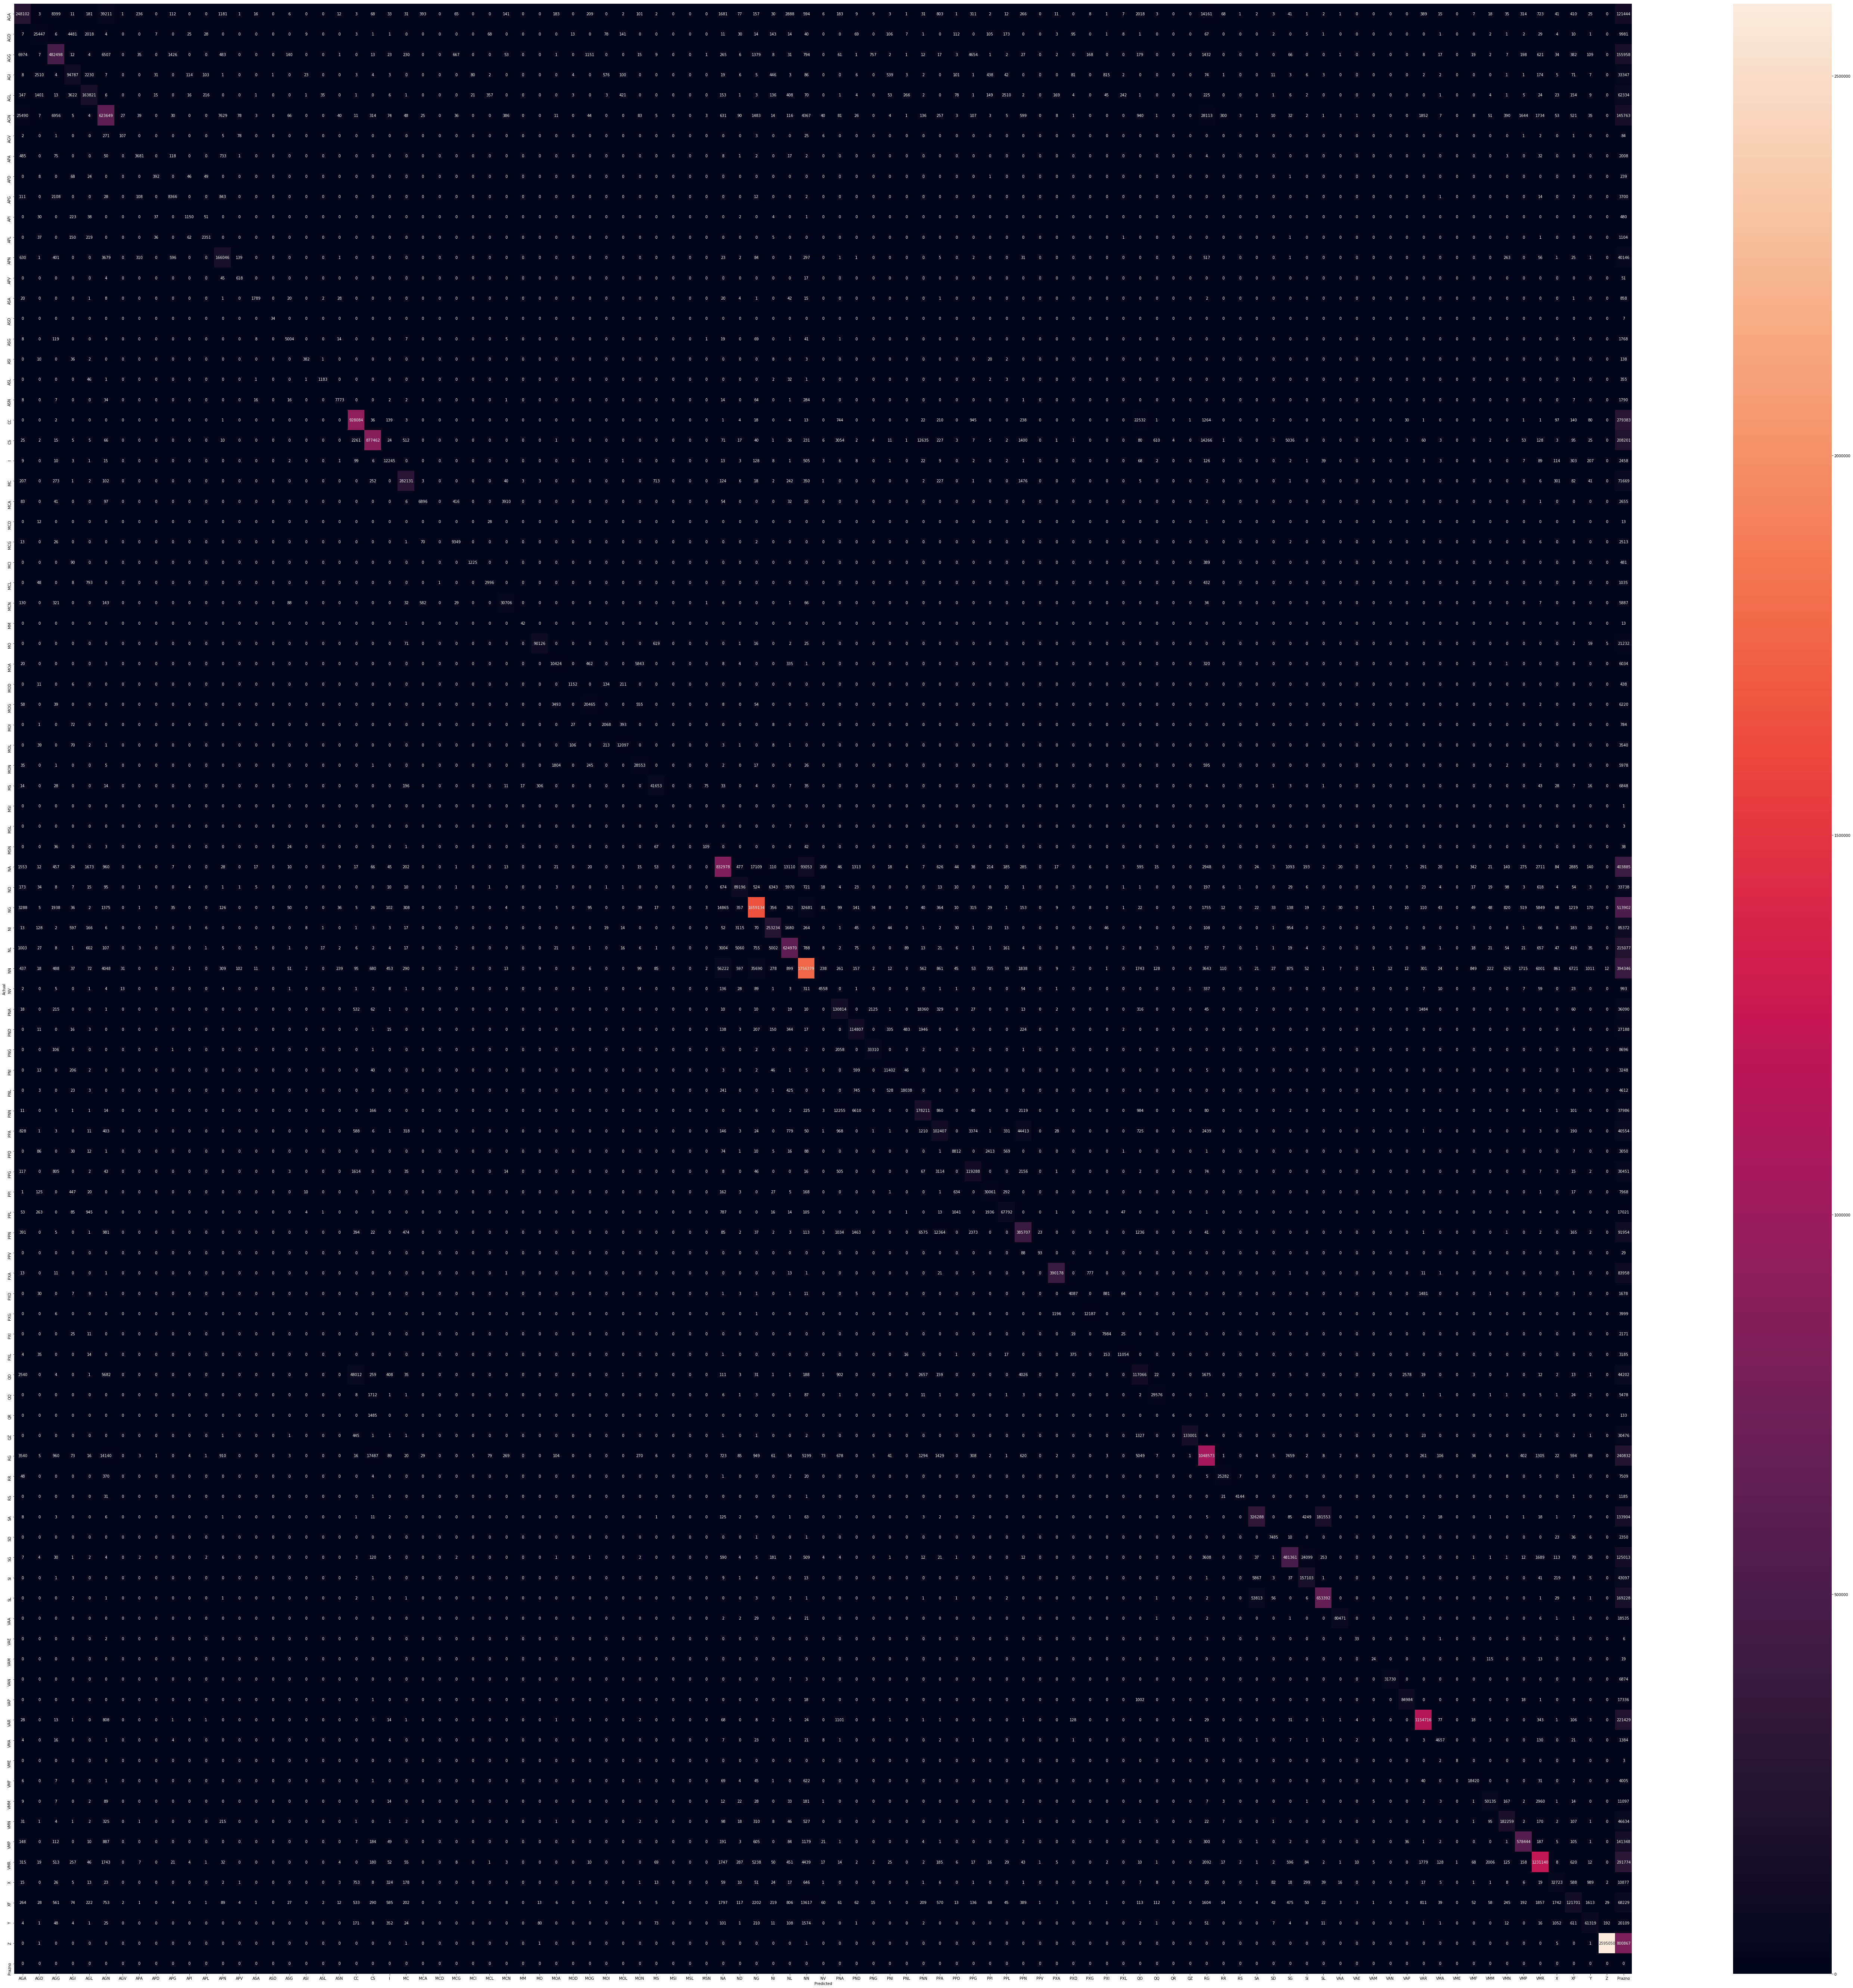

In [12]:
tagger_name = "bigram-tagger"
print("######## {} #######".format(tagger_name))

trainer = Trainer(corpus_root=srwac_corpus_root, 
	training_file=srwac_training_file, 
	corpus_name=corpus_name, 
	tagger_name=tagger_name,
	models_dir="/home/nikola/Desktop/NLP Nikola/Models")

model_path = trainer.train()
model_name = corpus_name + "-" + tagger_name
evaluator = Evaluator(model_path, model_name, srwac_corpus_root, srwac_training_file, srwac_testing_file, True)
evaluator.evaluate()
print("##############################")

### Trigram tagger

######## trigram-tagger #######
Training the tagger...
Dumping tagger...
Loading tagger model...
Loading test sentences...
Stripping tags from test sentences...
Stripping tags done.
Stripping words from sentences...

Tagger started tagging...
Tagger finished.
Stripping words from sentences...

Evaluating...
Accuracy :  0.6461320214469474
Creating confusion matrix...
##############################


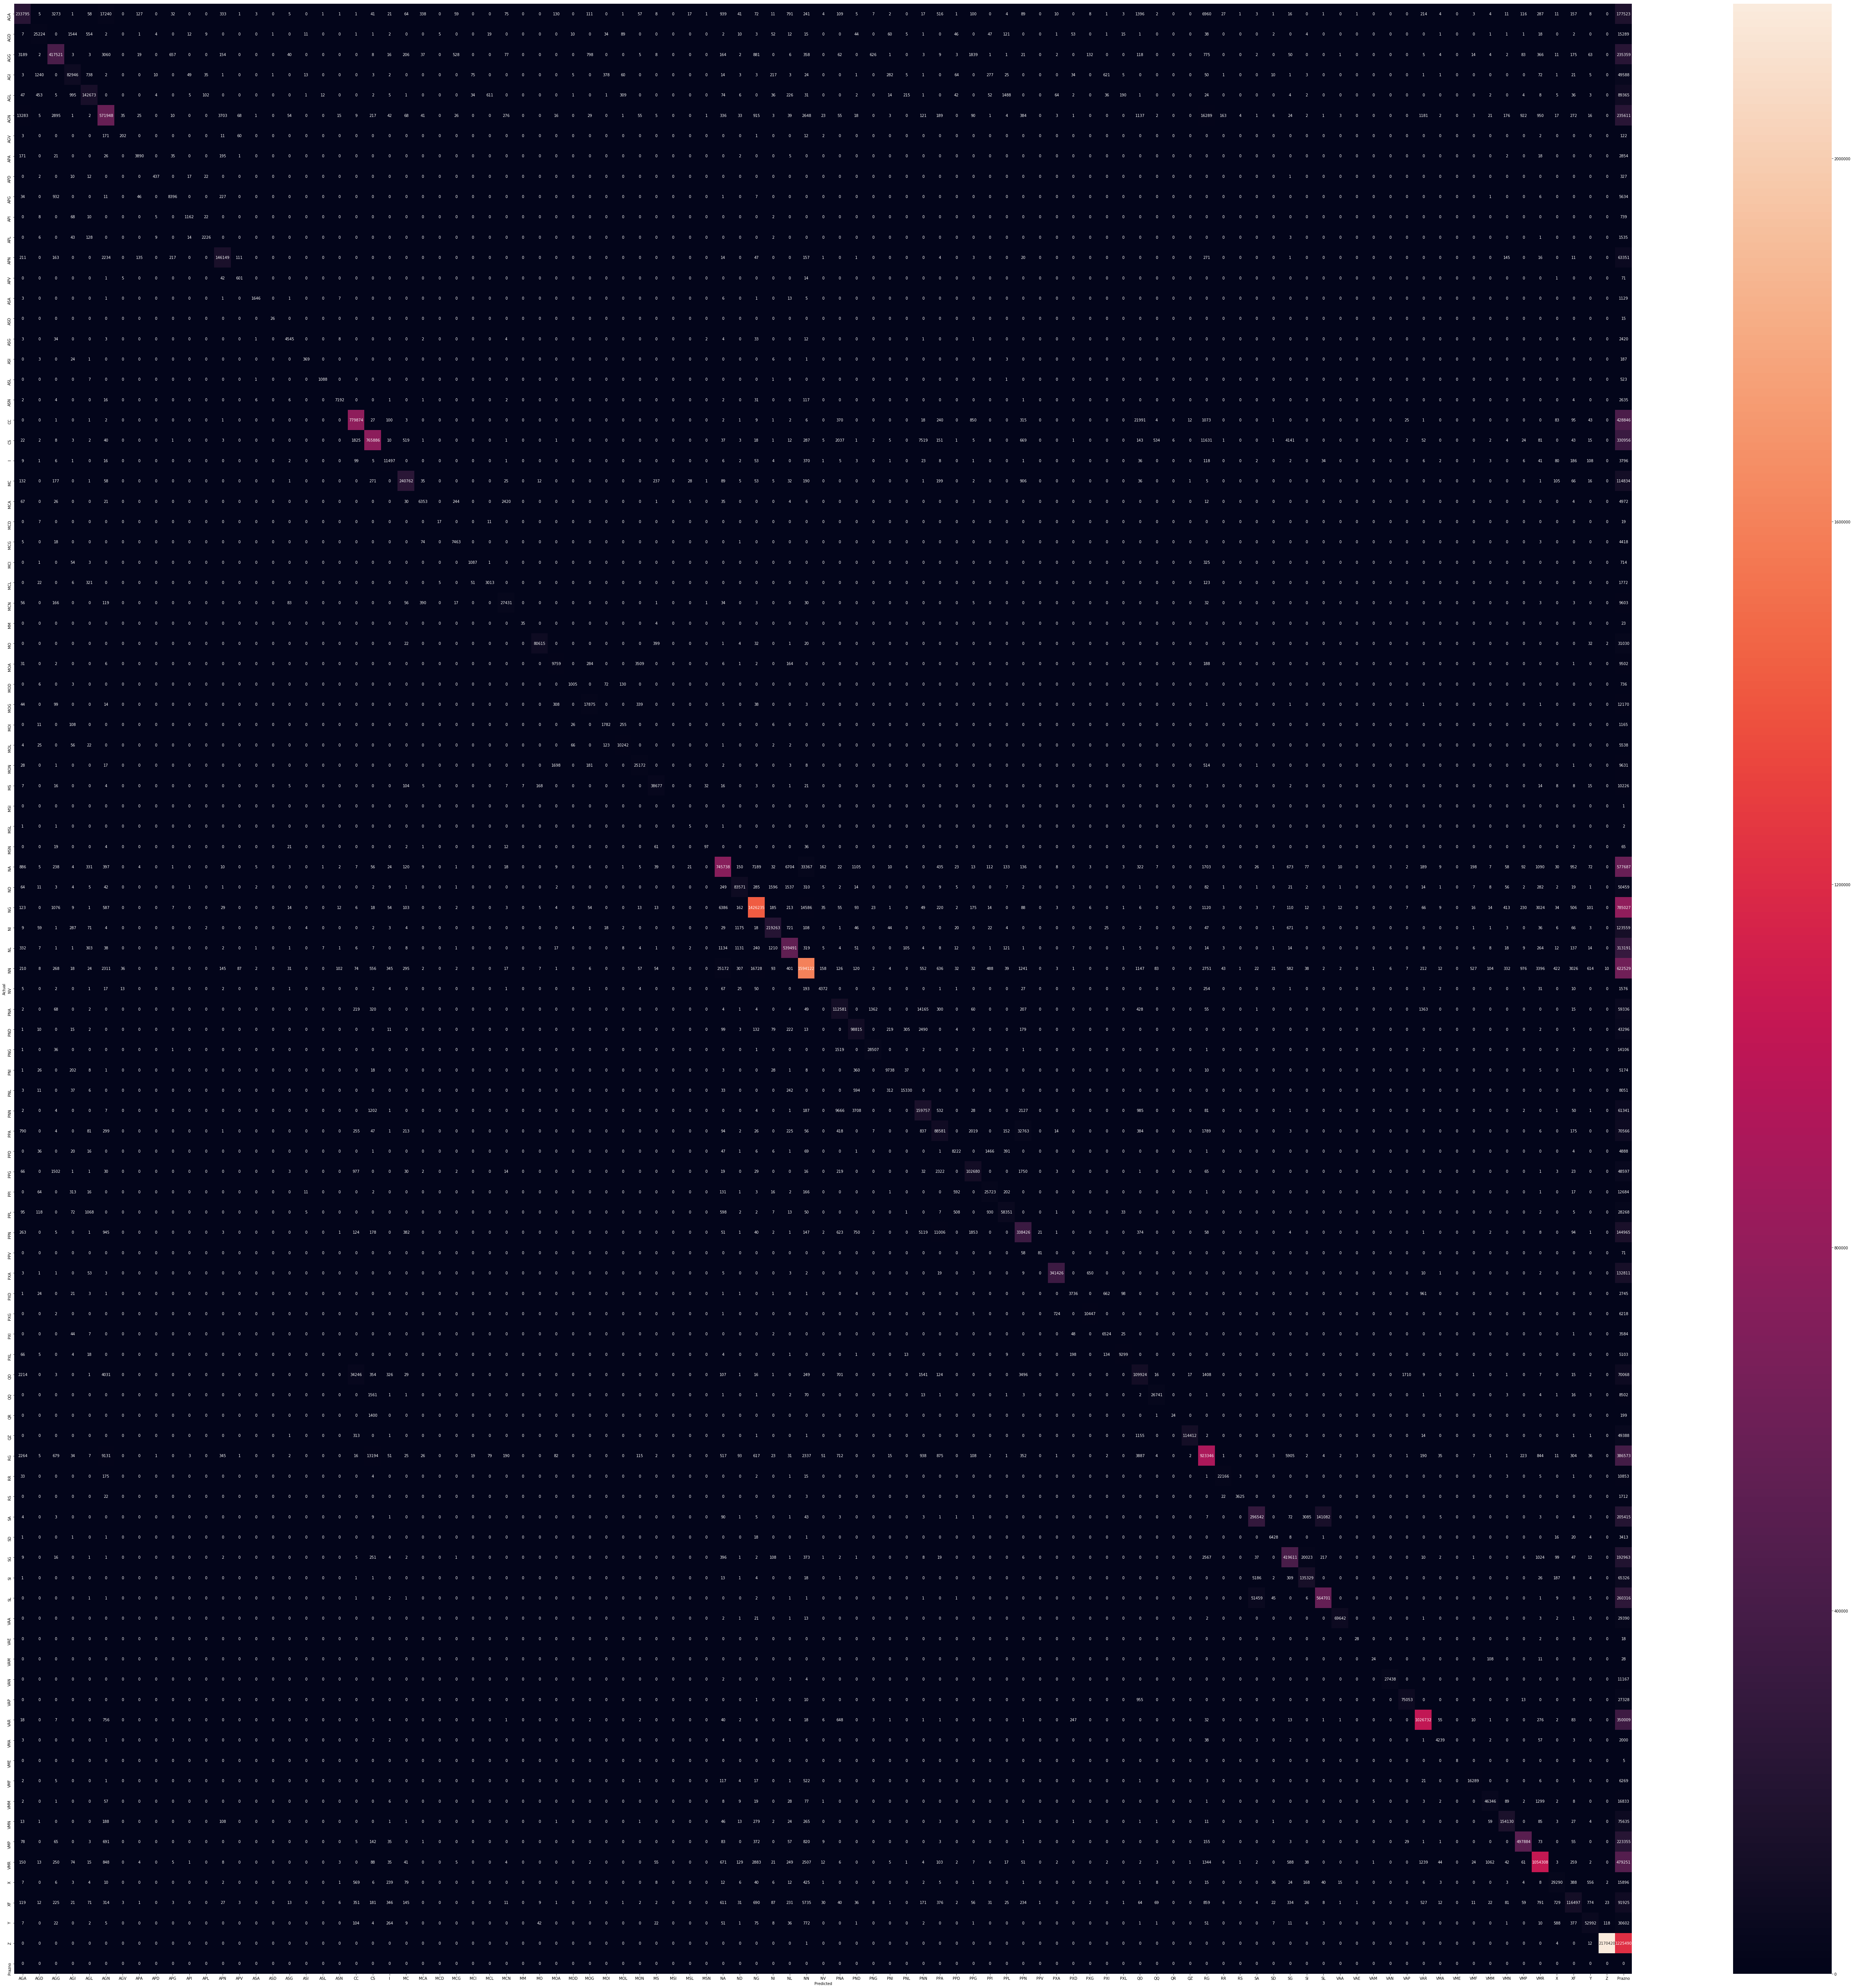

In [11]:
tagger_name = "trigram-tagger"
print("######## {} #######".format(tagger_name))

trainer = Trainer(corpus_root=srwac_corpus_root, 
	training_file=srwac_training_file, 
	corpus_name=corpus_name, 
	tagger_name=tagger_name,
	models_dir="/home/nikola/Desktop/NLP Nikola/Models")

model_path = trainer.train()
trigram_model = model_path
model_name = corpus_name + "-" + tagger_name
evaluator = Evaluator(model_path, model_name, srwac_corpus_root, srwac_training_file, srwac_testing_file, True)
evaluator.evaluate()
print("##############################")

### TNT tagger

In [8]:
tagger_name = "tnt-tagger"
print("######## {} #######".format(tagger_name))

trainer = Trainer(corpus_root=srwac_corpus_root, 
	training_file=srwac_training_file, 
	corpus_name=corpus_name, 
	tagger_name=tagger_name,
	models_dir="/home/nikola/Desktop/NLP Nikola/Models")

model_path = trainer.train()
model_name = corpus_name + "-" + tagger_name
evaluator = Evaluator(model_path, model_name, srwac_corpus_root, srwac_training_file, srwac_testing_file, True)
evaluator.evaluate()
print("##############################")

######## tnt-tagger #######
Training the tagger...
Dumping tagger...
Loading tagger model...
Loading test sentences...
Stripping tags from test sentences...
Stripping tags done.
Stripping words from sentences...

Tagger started tagging...


KeyboardInterrupt: 

### Perceptron tagger 

######## perceptron-tagger #######
Training the tagger...
Dumping tagger...
Loading tagger model...
Loading test sentences...
Stripping tags from test sentences...
Stripping tags done.
Stripping words from sentences...

Tagger started tagging...
Tagger finished.
Stripping words from sentences...

Evaluating...
Accuracy :  0.9728380533807879
Creating confusion matrix...
##############################


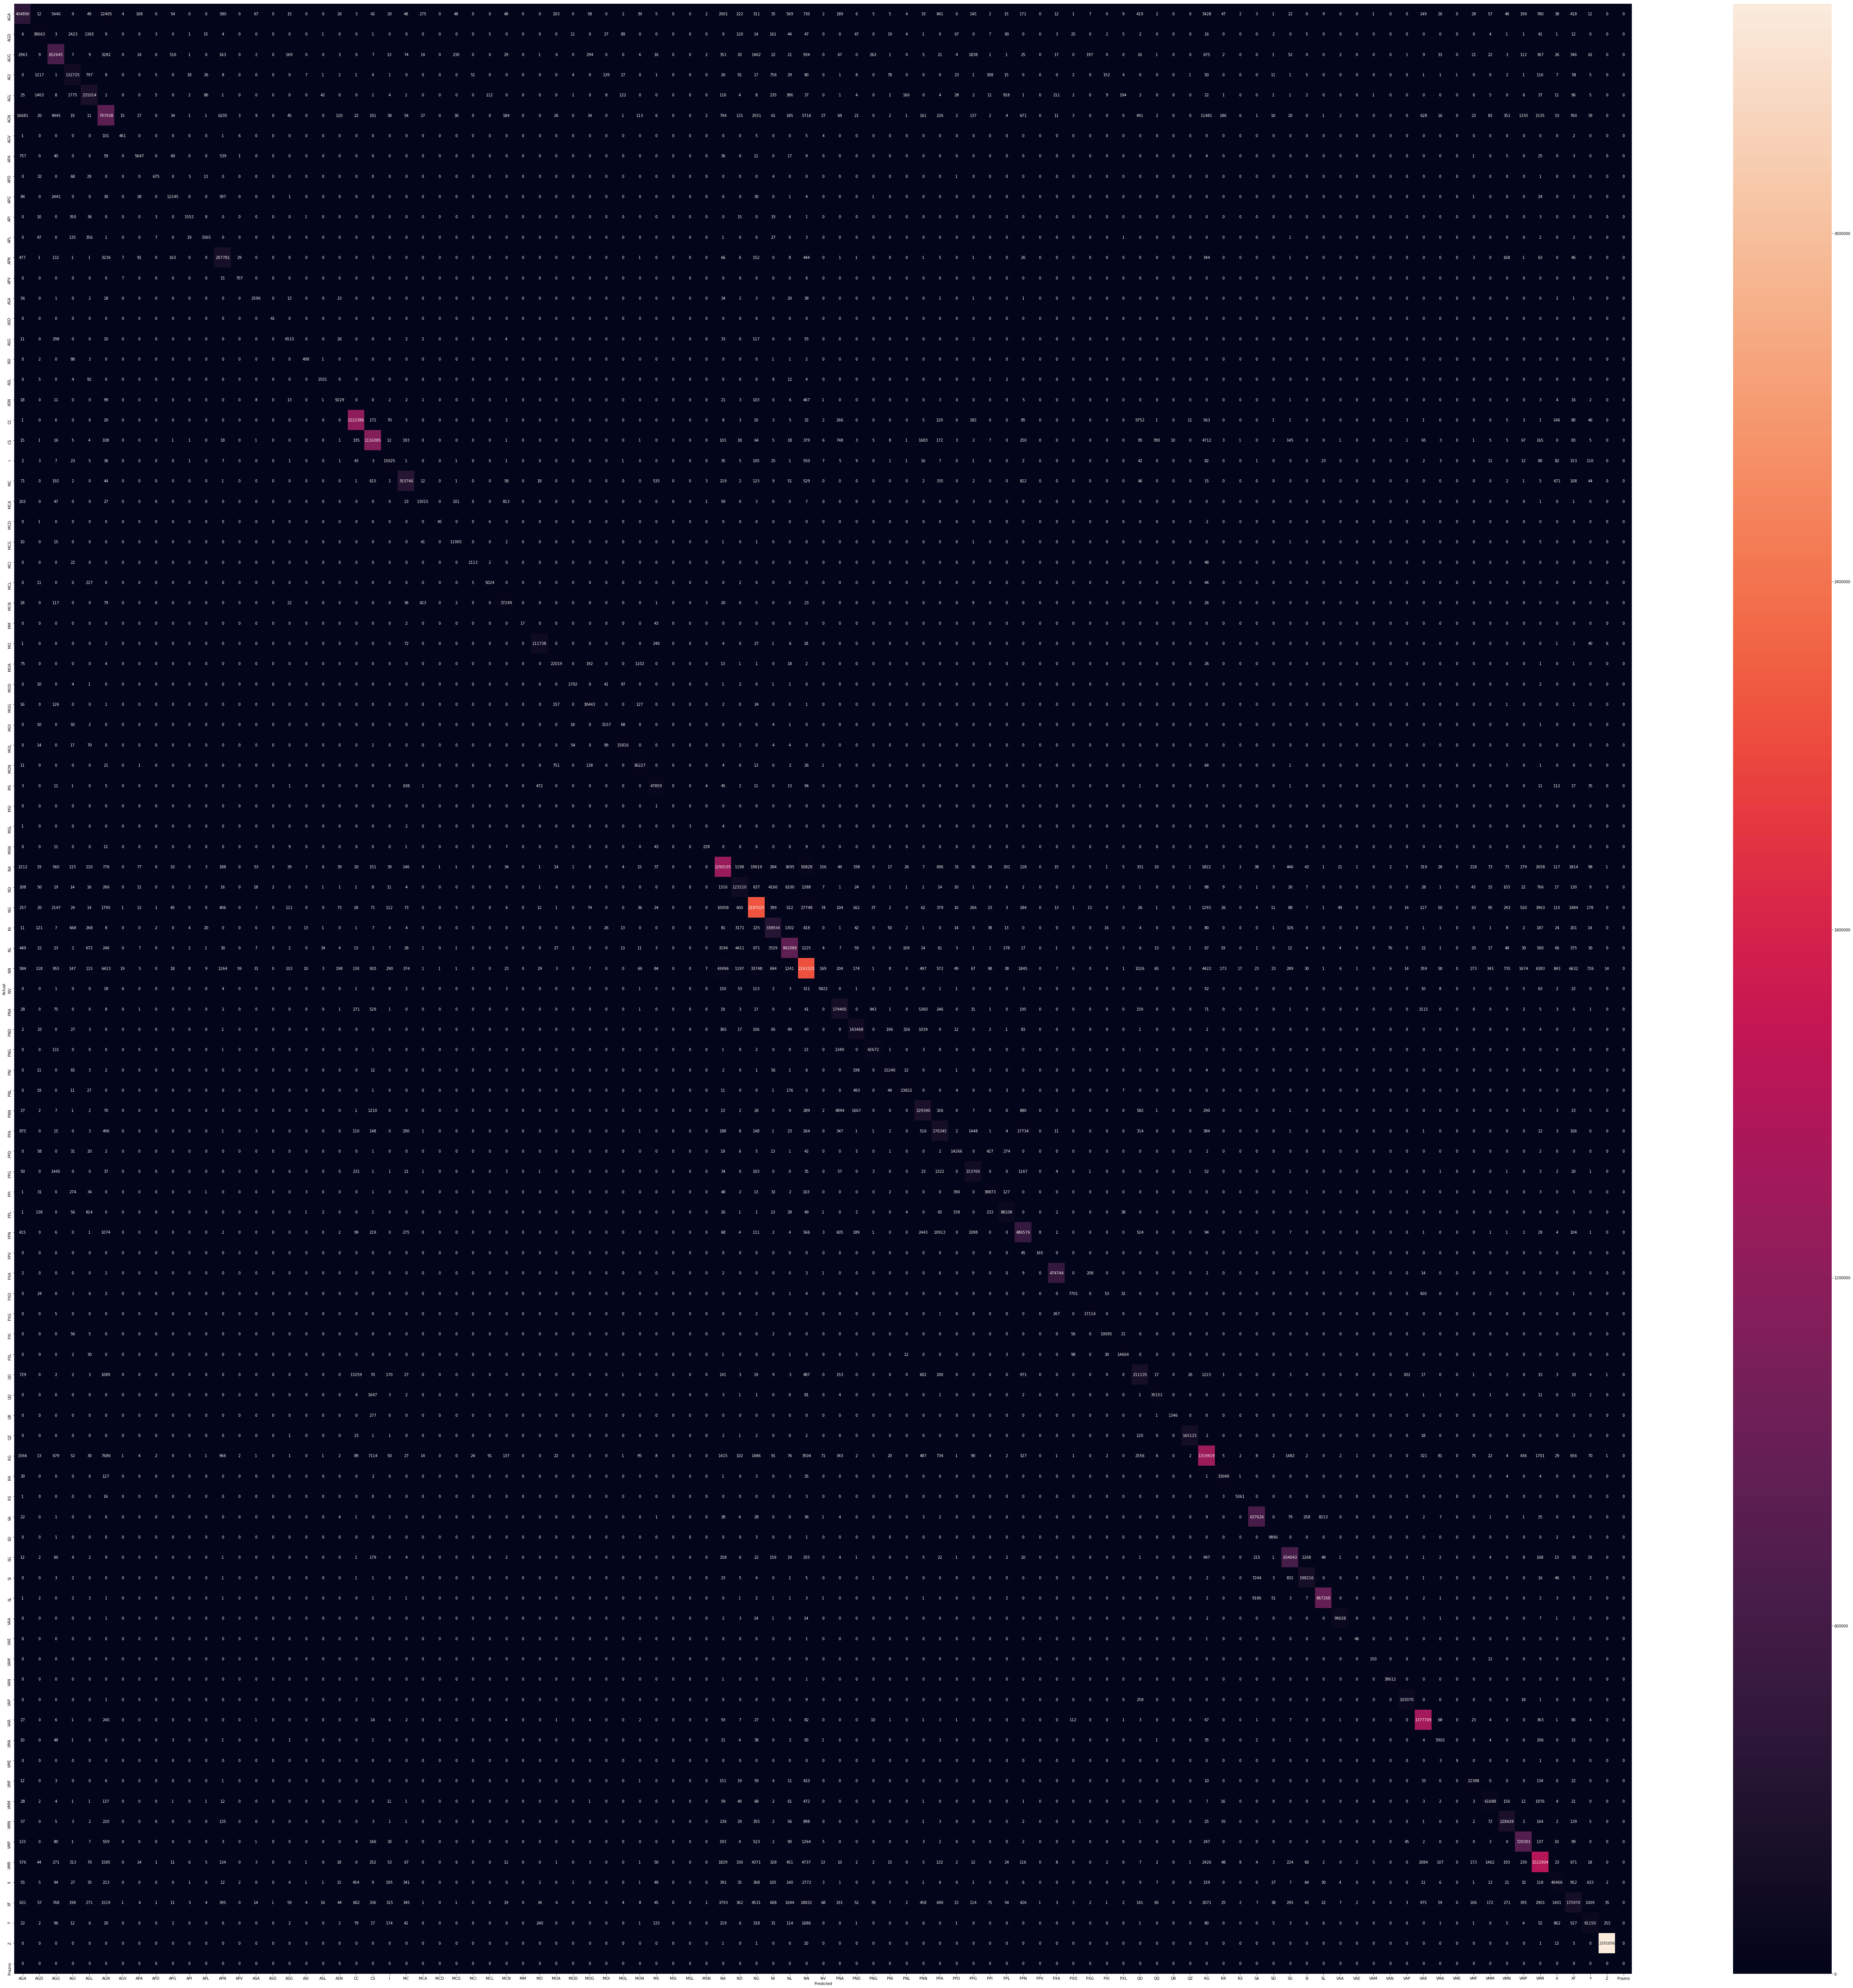

In [7]:
tagger_name = "perceptron-tagger"
print("######## {} #######".format(tagger_name))

trainer = Trainer(corpus_root=srwac_corpus_root, 
	training_file=srwac_training_file, 
	corpus_name=corpus_name, 
	tagger_name=tagger_name,
	models_dir="/home/nikola/Desktop/NLP Nikola/Models")

model_path = trainer.train()
model_name = corpus_name + "-" + tagger_name
evaluator = Evaluator(model_path, model_name, srwac_corpus_root, srwac_training_file, srwac_testing_file, True)
evaluator.evaluate()
print("##############################")

######## combined-tagger #######
Training the tagger...
Dumping tagger...
Loading tagger model...
Loading test sentences...
Stripping tags from test sentences...
Stripping tags done.
Stripping words from sentences...

Tagger started tagging...
Tagger finished.
Stripping words from sentences...

Evaluating...
Accuracy :  0.9472735737413729
Creating confusion matrix...
##############################


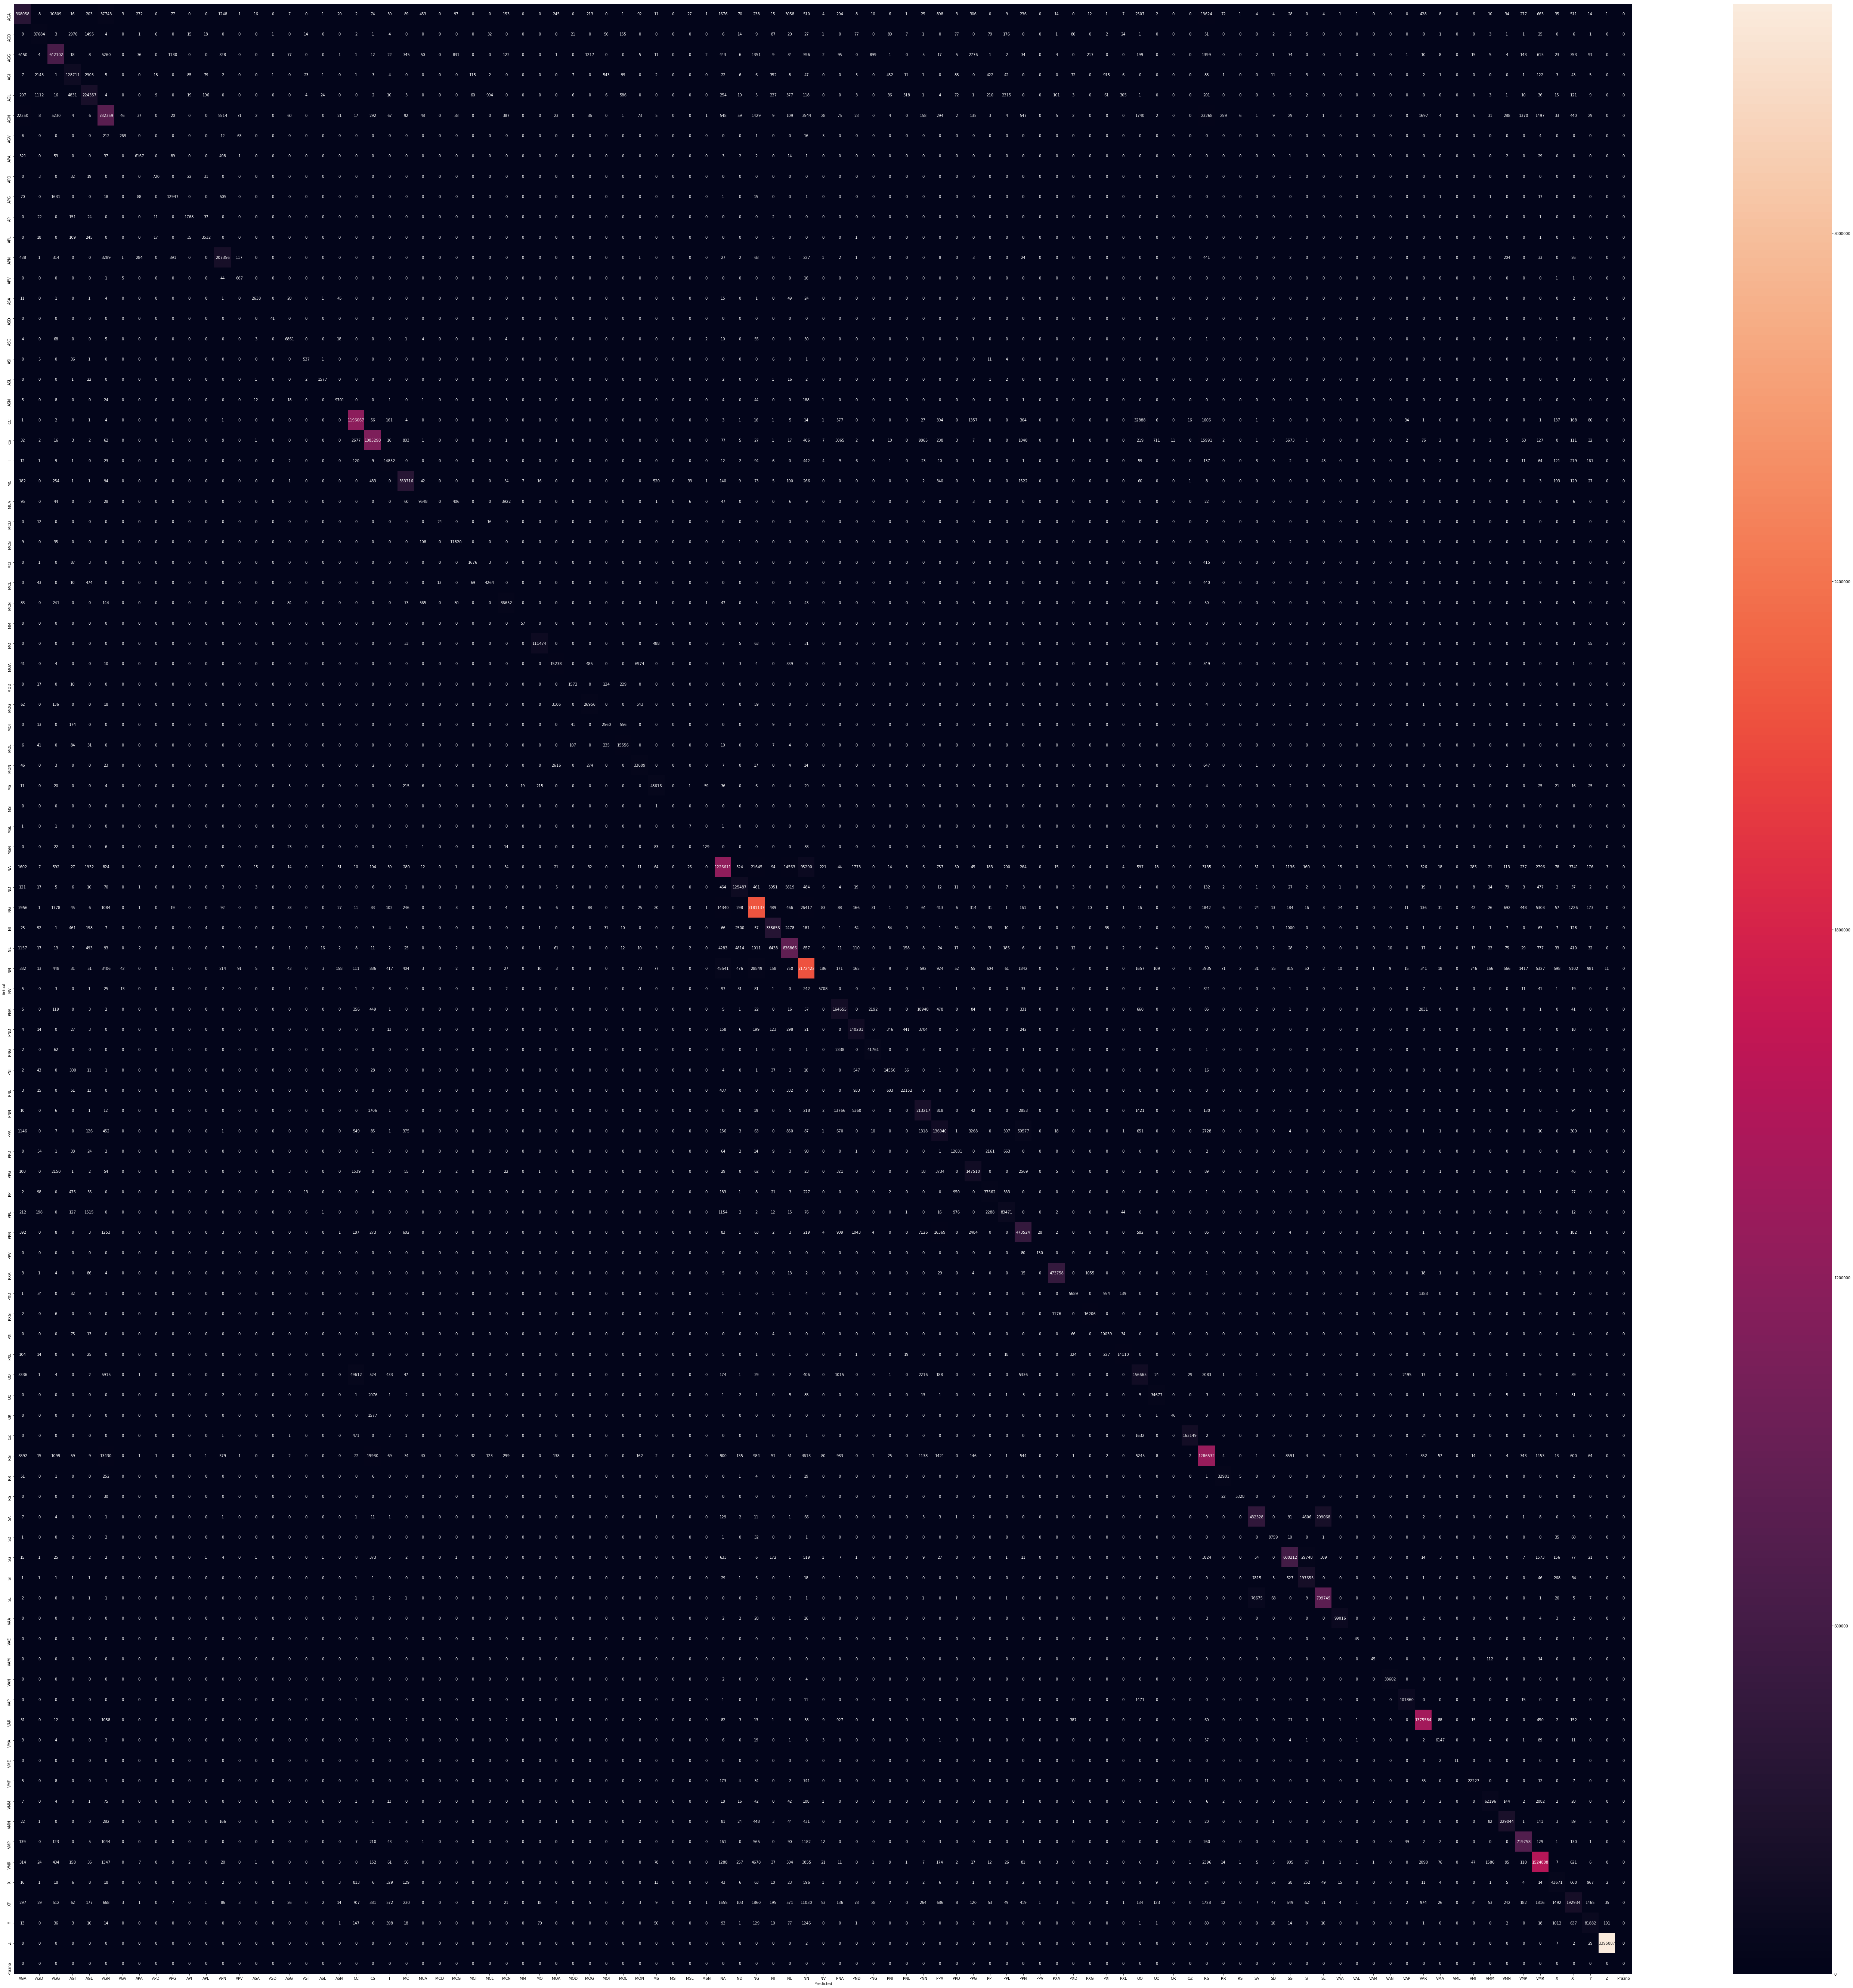

In [6]:
tagger_name = 'combined-tagger'
print("######## {} #######".format(tagger_name))

trainer = Trainer(corpus_root=srwac_corpus_root, 
	training_file=srwac_training_file, 
	corpus_name=corpus_name, 
	tagger_name=tagger_name,
	models_dir="/home/nikola/Desktop/NLP Nikola/Models")

model_path = trainer.train()
trigram_model = model_path
model_name = corpus_name + "-" + tagger_name
evaluator = Evaluator(model_path, model_name, srwac_corpus_root, srwac_training_file, srwac_testing_file, True)
evaluator.evaluate()
print("##############################")

In [14]:
print("Hello 20.11.2022!")


Hello 20.11.2022!


# Testiranje recce DA - Unigram
## kaze da je da pomocni veznik

In [26]:
filename = '/home/nikola/Desktop/NLP Nikola/Models/srWaC_unigram-tagger.pickle'
unigram_model = pickle.load(open(filename, 'rb'))
print(unigram_model.tag_sents([["Idem", "da","sednem", "."]]))
print(unigram_model.tag_sents([["Nikako", "ne","mogu", "da", "stignem", "to", "da", "uradim", "."]]))
print(unigram_model.tag_sents([["Vi", "znate", "da", "je", "Marko", "oženjen", "?",  "Da", ",",  "bio",  "sam", "na",  "svadbi", "."]]))


[[('Idem', 'VMR'), ('da', 'CS'), ('sednem', 'VMR'), ('.', 'Z')]]
[[('Nikako', 'RG'), ('ne', 'QZ'), ('mogu', 'VMR'), ('da', 'CS'), ('stignem', 'VMR'), ('to', 'PPN'), ('da', 'CS'), ('uradim', 'VMR'), ('.', 'Z')]]
[[('Vi', 'PNN'), ('znate', 'VMR'), ('da', 'CS'), ('je', 'VAR'), ('Marko', 'NN'), ('oženjen', 'APN'), ('?', 'Z'), ('Da', 'CS'), (',', 'Z'), ('bio', 'VAP'), ('sam', 'VAR'), ('na', 'SA'), ('svadbi', 'NL'), ('.', 'Z')]]


In [25]:
filename = '/home/nikola/Desktop/NLP Nikola/Models/srWaC_perceptron-tagger.pickle'
perceptron_model = pickle.load(open(filename, 'rb'))
print(perceptron_model.tag_sents([["Idem", "da","sednem", "."]]))
print(perceptron_model.tag_sents([["Nikako", "ne","mogu", "da", "stignem", "to", "da", "uradim", "."]]))
print(perceptron_model.tag_sents([["Vi", "znate", "da", "je", "Marko", "oženjen", "?",  "Da", ",",  "bio",  "sam", "na",  "svadbi", "."]]))

[[('Idem', 'VMR'), ('da', 'CS'), ('sednem', 'VMR'), ('.', 'Z')]]
[[('Nikako', 'RG'), ('ne', 'QZ'), ('mogu', 'VMR'), ('da', 'CS'), ('stignem', 'VMR'), ('to', 'PPA'), ('da', 'CS'), ('uradim', 'VMR'), ('.', 'Z')]]
[[('Vi', 'PNN'), ('znate', 'VMR'), ('da', 'CS'), ('je', 'VAR'), ('Marko', 'NN'), ('oženjen', 'APN'), ('?', 'Z'), ('Da', 'QR'), (',', 'Z'), ('bio', 'VAP'), ('sam', 'VAR'), ('na', 'SL'), ('svadbi', 'NL'), ('.', 'Z')]]


In [24]:
filename = '/home/nikola/Desktop/NLP Nikola/Models/srWaC_combined-tagger.pickle'
combined_model = pickle.load(open(filename, 'rb'))
print(combined_model.tag_sents([["Idem", "da","sednem", "."]]))
print(combined_model.tag_sents([["Nikako", "ne","mogu", "da", "stignem", "to", "da", "uradim", "."]]))
print(combined_model.tag_sents([["Vi", "znate", "da", "je", "Marko", "oženjen", "?",  "Da", ",",  "bio",  "sam", "na",  "svadbi", "."]]))

[[('Idem', 'VMR'), ('da', 'CS'), ('sednem', 'VMR'), ('.', 'Z')]]
[[('Nikako', 'RG'), ('ne', 'QZ'), ('mogu', 'VMR'), ('da', 'CS'), ('stignem', 'VMR'), ('to', 'PPA'), ('da', 'CS'), ('uradim', 'VMR'), ('.', 'Z')]]
[[('Vi', 'PNN'), ('znate', 'VMR'), ('da', 'CS'), ('je', 'VAR'), ('Marko', 'NN'), ('oženjen', 'APN'), ('?', 'Z'), ('Da', 'CS'), (',', 'Z'), ('bio', 'VAP'), ('sam', 'VAR'), ('na', 'SL'), ('svadbi', 'NL'), ('.', 'Z')]]


# Recca da - problem
## Skoro svi primeri u test korpusu su gde je da veznik

In [27]:
filename = '/home/nikola/Desktop/NLP Nikola/Models/srWaC_tnt-tagger.pickle'
tnt_model = pickle.load(open(filename, 'rb'))
print(tnt_model.tag_sents([["Idem", "da","sednem", "."]]))
print(tnt_model.tag_sents([["Nikako", "ne","mogu", "da", "stignem", "to", "da", "uradim", "."]]))
print(tnt_model.tag_sents([["Vi", "znate", "da", "je", "Marko", "oženjen", "?",  "Da", ",",  "bio",  "sam", "na",  "svadbi", "."]]))

[[('Idem', 'VMR'), ('da', 'CS'), ('sednem', 'VMR'), ('.', 'Z')]]
[[('Nikako', 'RG'), ('ne', 'QZ'), ('mogu', 'VMR'), ('da', 'CS'), ('stignem', 'VMR'), ('to', 'PPA'), ('da', 'CS'), ('uradim', 'VMR'), ('.', 'Z')]]
[[('Vi', 'PNN'), ('znate', 'VMR'), ('da', 'CS'), ('je', 'VAR'), ('Marko', 'NN'), ('oženjen', 'APN'), ('?', 'Z'), ('Da', 'QR'), (',', 'Z'), ('bio', 'VAP'), ('sam', 'VAR'), ('na', 'SL'), ('svadbi', 'NL'), ('.', 'Z')]]


# Perceptron i tnt pogadjaju reccu da
## Potencijalno resenje za Da i Ne reccu, je da ako iza toga sledi zapeta (Z) onda je recca 
## "Da li" kakvi tagovi treba da budu u ovom slucaju ? Jer su dve reci...

In [42]:
#Da li znaš ko ima domaći zdatak?
print(unigram_model.tag_sents([["Da", "li", "znaš", "ko", "ima", "domaći", "zdatak","?"]]))
print(unigram_model.tag_sents([["Da li", "znaš", "ko", "ima", "domaći", "zdatak","?"]]))

[[('Da', 'CS'), ('li', 'QQ'), ('znaš', 'VMR'), ('ko', 'CS'), ('ima', 'VMR'), ('domaći', 'AGN'), ('zdatak', None), ('?', 'Z')]]
[[('Da li', None), ('znaš', 'VMR'), ('ko', 'CS'), ('ima', 'VMR'), ('domaći', 'AGN'), ('zdatak', None), ('?', 'Z')]]


In [30]:
#Da li znaš ko ima domaći zdatak?
print(perceptron_model.tag_sents([["Da", "li", "znaš", "ko", "ima", "domaći", "zdatak","?"]]))
print(perceptron_model.tag_sents([["Da li", "znaš", "ko", "ima", "domaći", "zdatak","?"]]))

[[('Da', 'CS'), ('li', 'QQ'), ('znaš', 'VMR'), ('ko', 'CS'), ('ima', 'VMR'), ('domaći', 'AGA'), ('zdatak', 'NA'), ('?', 'Z')]]
[[('Da li', 'NN'), ('znaš', 'VMR'), ('ko', 'CS'), ('ima', 'VMR'), ('domaći', 'AGA'), ('zdatak', 'NA'), ('?', 'Z')]]


In [32]:
#Da li znaš ko ima domaći zdatak?
# Gresi na "ko", jel treba pnn???
print(tnt_model.tag_sents([["Da", "li", "znaš", "ko", "ima", "domaći", "zdatak","?"]]))
print(tnt_model.tag_sents([["Da li", "znaš", "ko", "ima", "domaći", "zdatak","?"]]))

[[('Da', 'CS'), ('li', 'QQ'), ('znaš', 'VMR'), ('ko', 'CS'), ('ima', 'VMR'), ('domaći', 'AGN'), ('zdatak', 'Unk'), ('?', 'Z')]]
[[('Da li', 'Unk'), ('znaš', 'VMR'), ('ko', 'CS'), ('ima', 'VMR'), ('domaći', 'AGN'), ('zdatak', 'Unk'), ('?', 'Z')]]


In [33]:
#Da li znaš ko ima domaći zdatak?
print(combined_model.tag_sents([["Da", "li", "znaš", "ko", "ima", "domaći", "zdatak","?"]]))
print(combined_model.tag_sents([["Da li", "znaš", "ko", "ima", "domaći", "zdatak","?"]]))

[[('Da', 'CS'), ('li', 'QQ'), ('znaš', 'VMR'), ('ko', 'CS'), ('ima', 'VMR'), ('domaći', 'AGA'), ('zdatak', 'NN'), ('?', 'Z')]]
[[('Da li', 'NN'), ('znaš', 'VMR'), ('ko', 'CS'), ('ima', 'VMR'), ('domaći', 'AGA'), ('zdatak', 'NN'), ('?', 'Z')]]


# Ideja
## Prosirujemo evaluator koji ce u fajl da upisuje pogresno tagovane reci
## Naci nacin za zamenu modela kod nekih konkretnih pravila
### Proveriti za hijerarhijski, da li smo dobro shvatili jer izgleda da algoritmi funkcionisu tako sto odmah odredjuju vrstu i podvrstu, a ne prvo vrstu pa podvrstu, problem da li je moguce odvojiti jedan algoritam za vrstu a drugi za podvrstu? Jer mi imamo vec kompletne tagove sa kojim se trenira

## Imenicke nelicne zamenice zezaju! Naci pravilo.

In [41]:
print(unigram_model.tag_sents([["Ko", "nije", "uradio", "domaci", "dobice", "1", "."]]))
print(unigram_model.tag_sents([["Ko", "nema", "domaci", "dobice", "1", "."]]))
print(unigram_model.tag_sents([["Dobice", "1", "onaj", "ko", "nema", "domaci", "."]]))

[[('Ko', 'PNN'), ('nije', 'VAR'), ('uradio', 'VMP'), ('domaci', 'AGN'), ('dobice', 'VMF'), ('1', 'MC'), ('.', 'Z')]]
[[('Ko', 'PNN'), ('nema', 'VMR'), ('domaci', 'AGN'), ('dobice', 'VMF'), ('1', 'MC'), ('.', 'Z')]]
[[('Dobice', 'VMF'), ('1', 'MC'), ('onaj', 'PPN'), ('ko', 'CS'), ('nema', 'VMR'), ('domaci', 'AGN'), ('.', 'Z')]]


In [37]:
# "Ko", "nije", "uradio", "domaci", "dobice", "1", "."
print(perceptron_model.tag_sents([["Ko", "nije", "uradio", "domaci", "dobice", "1", "."]]))
print(perceptron_model.tag_sents([["Ko", "nema", "domaci", "dobice", "1", "."]]))
print(perceptron_model.tag_sents([["Dobice", "1", "onaj", "ko", "nema", "domaci", "."]]))


[[('Ko', 'PNN'), ('nije', 'VAR'), ('uradio', 'VMP'), ('domaci', 'AGN'), ('dobice', 'VMF'), ('1', 'MC'), ('.', 'Z')]]
[[('Ko', 'CS'), ('nema', 'VMR'), ('domaci', 'AGN'), ('dobice', 'VMF'), ('1', 'MC'), ('.', 'Z')]]
[[('Dobice', 'VMF'), ('1', 'MC'), ('onaj', 'PPN'), ('ko', 'CS'), ('nema', 'VMR'), ('domaci', 'AGN'), ('.', 'Z')]]


In [47]:
# "Ko", "nije", "uradio", "domaci", "dobice", "1", "."
print(combined_model.tag_sents([["Ko", "nije", "uradio", "domaci", "dobice", "1", "."]]))
print(combined_model.tag_sents([["Ko", "nema", "domaci", "dobice", "1", "."]]))
print(combined_model.tag_sents([["Dobice", "1", "onaj", "ko", "nema", "domaci", "."]]))

[[('Ko', 'PNN'), ('nije', 'VAR'), ('uradio', 'VMP'), ('domaci', 'AGN'), ('dobice', 'VMF'), ('1', 'MC'), ('.', 'Z')]]
[[('Ko', 'PNN'), ('nema', 'VMR'), ('domaci', 'AGN'), ('dobice', 'VMF'), ('1', 'MC'), ('.', 'Z')]]
[[('Dobice', 'VMF'), ('1', 'MC'), ('onaj', 'PPN'), ('ko', 'CS'), ('nema', 'VMR'), ('domaci', 'AGN'), ('.', 'Z')]]


In [38]:
# "Ko", "nije", "uradio", "domaci", "dobice", "1", "."
print(tnt_model.tag_sents([["Ko", "nije", "uradio", "domaci", "dobice", "1", "."]]))
print(tnt_model.tag_sents([["Ko", "nema", "domaci", "dobice", "1", "."]]))
print(tnt_model.tag_sents([["Dobice", "1", "onaj", "ko", "nema", "domaci", "."]]))

[[('Ko', 'PNN'), ('nije', 'VAR'), ('uradio', 'VMP'), ('domaci', 'AGA'), ('dobice', 'VMF'), ('1', 'MC'), ('.', 'Z')]]
[[('Ko', 'CS'), ('nema', 'VMR'), ('domaci', 'AGA'), ('dobice', 'VMF'), ('1', 'MC'), ('.', 'Z')]]
[[('Dobice', 'VMF'), ('1', 'MC'), ('onaj', 'PPN'), ('ko', 'CS'), ('nema', 'VMR'), ('domaci', 'AGN'), ('.', 'Z')]]


# HMM Tager

######## hmm-tagger #######
Training the tagger...
Dumping tagger...
Loading tagger model...
Loading test sentences...
Stripping tags from test sentences...
Stripping tags done.
Stripping words from sentences...

Tagger started tagging...
Tagger finished.
Stripping words from sentences...

Evaluating...
Accuracy :  0.9388750375871359
Creating confusion matrix...
##############################


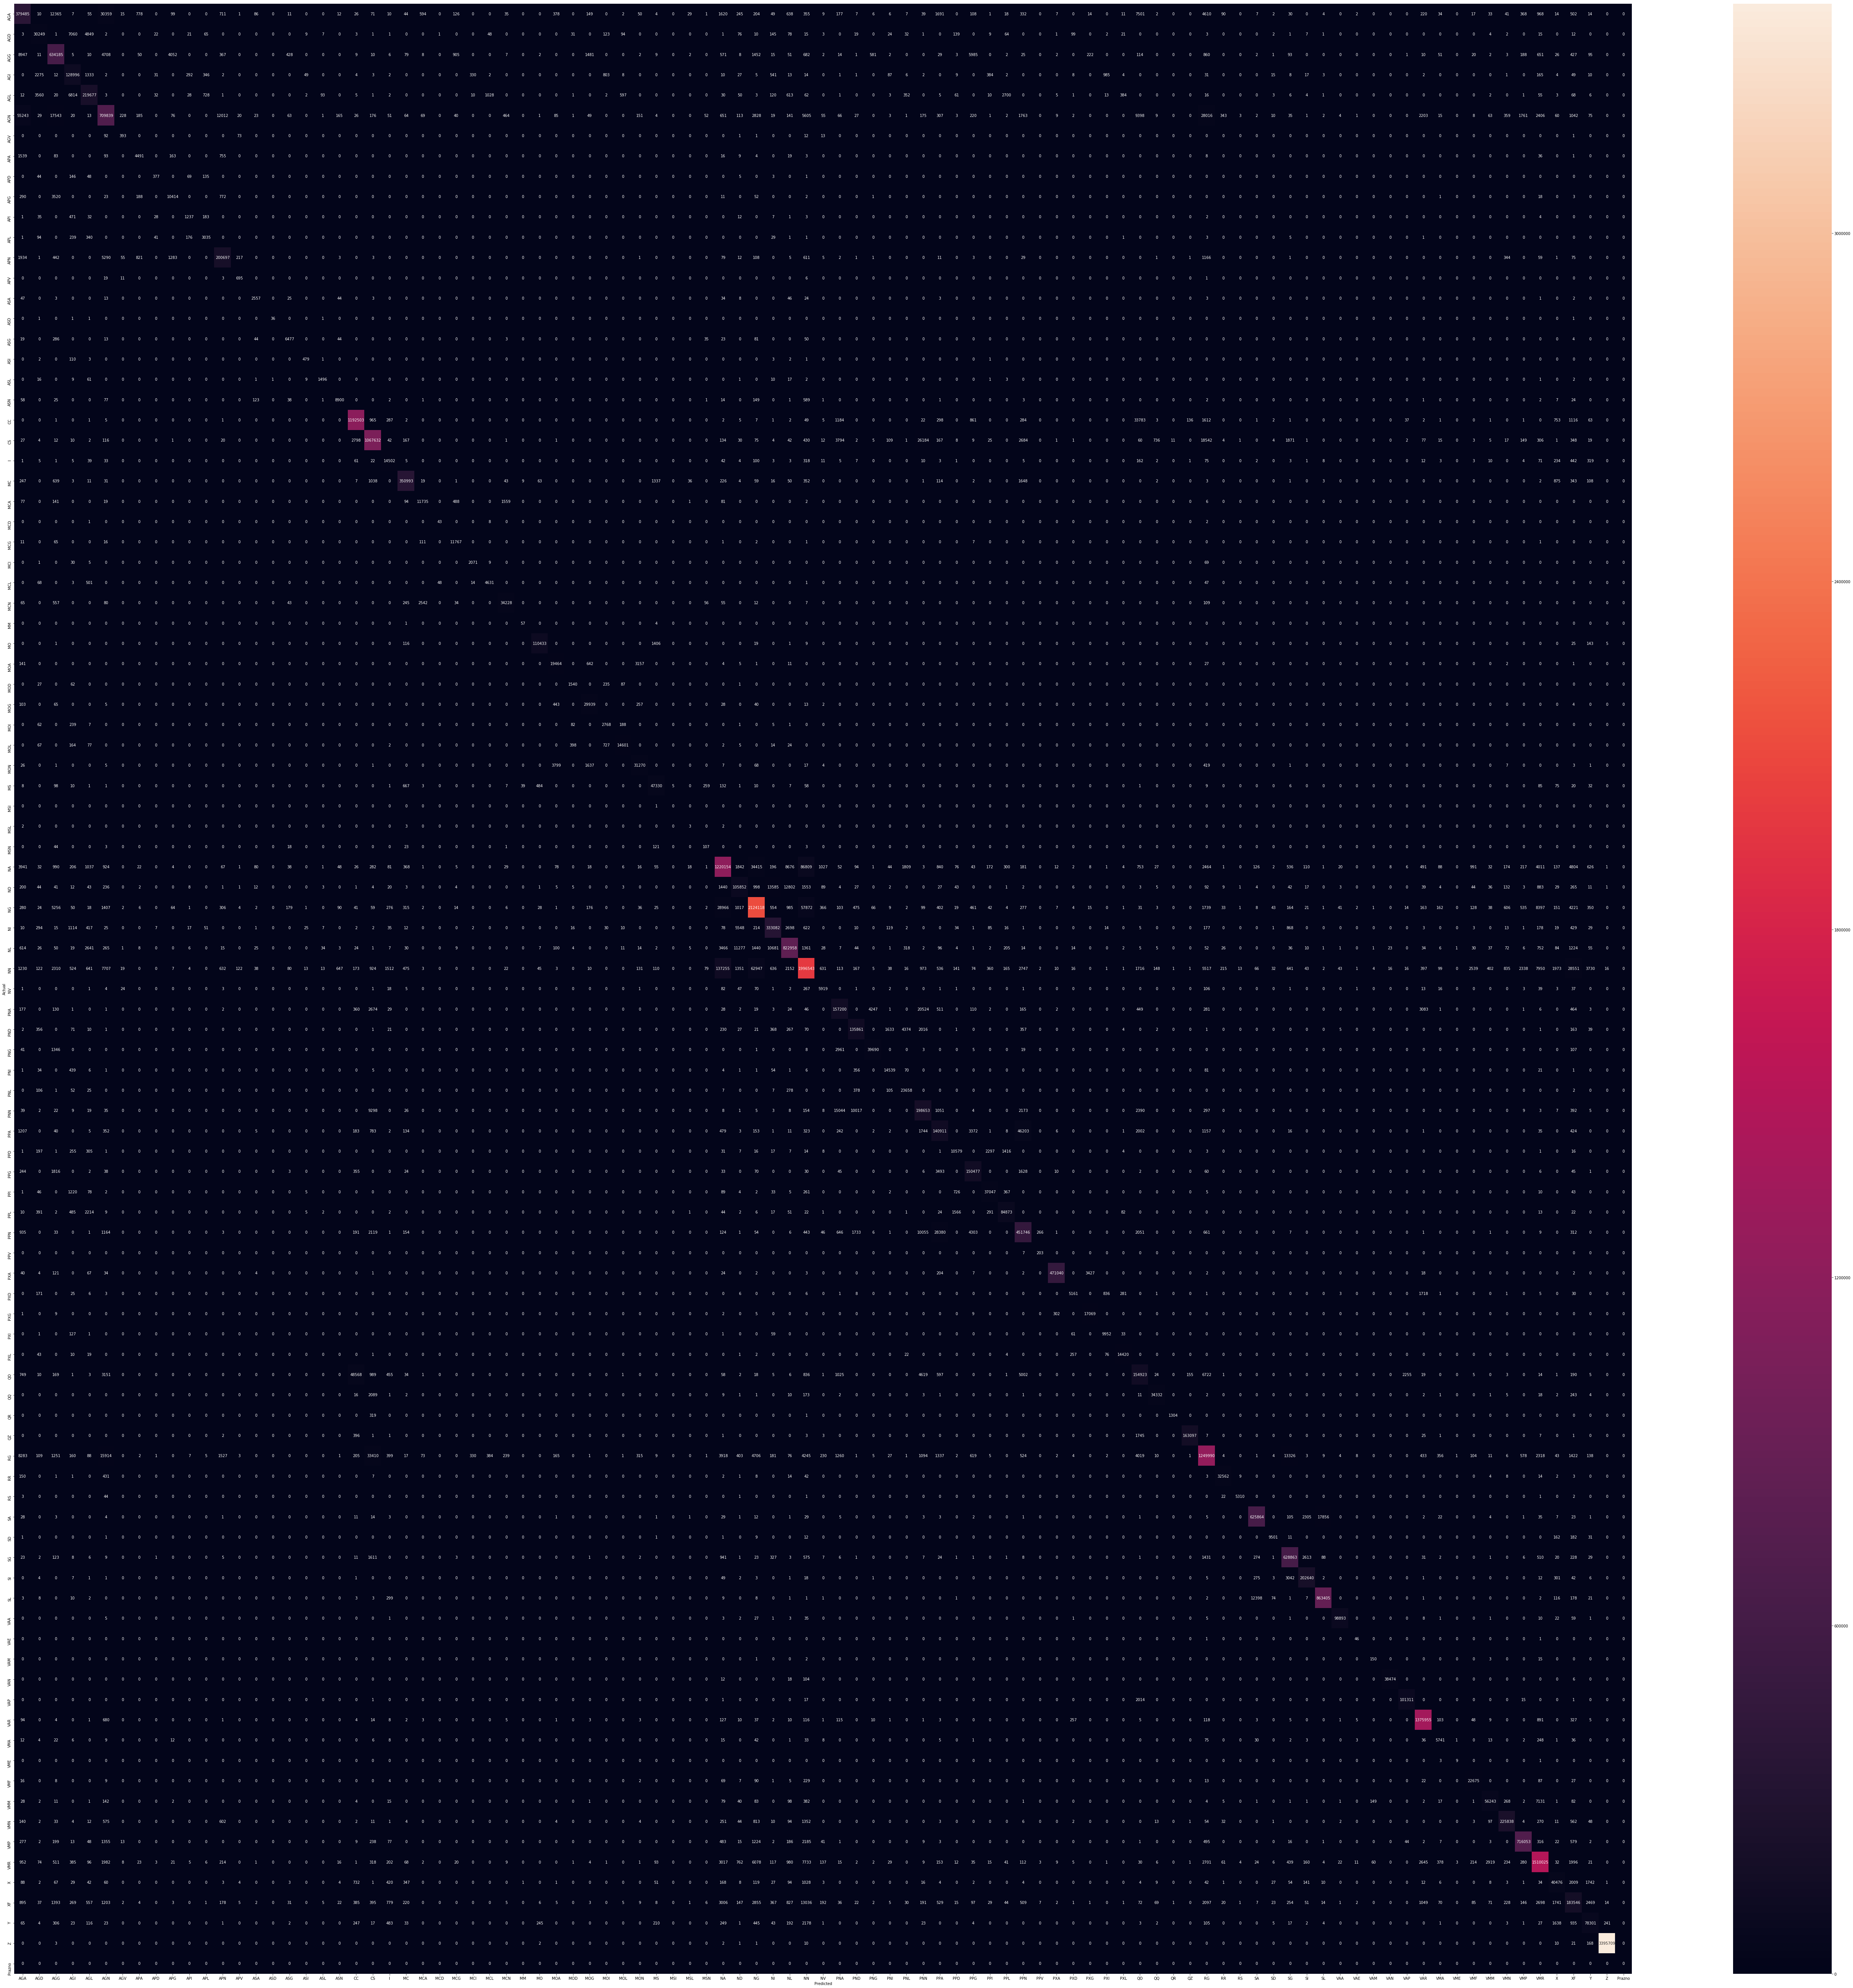

In [39]:
tagger_name = "hmm-tagger"
print("######## {} #######".format(tagger_name))


trainer = Trainer(corpus_root=srwac_corpus_root, 

  training_file=srwac_training_file, 
  corpus_name=corpus_name, 
  tagger_name=tagger_name,
  models_dir="/home/nikola/Desktop/NLP Nikola/Models")


model_path = trainer.train()
model_name = corpus_name + "-" + tagger_name
evaluator = Evaluator(model_path, model_name, srwac_corpus_root, srwac_training_file, srwac_testing_file, True)
evaluator.evaluate()
print("##############################")

# Reversed 

In [40]:
rev = reverse_corpus('/home/nikola/Desktop/NLP Nikola/srWaC1.1.06/srWaC1.1.06-o11.txt')

with open('/home/nikola/Desktop/NLP Nikola/srWaC1.1.06/srWaC1.1.06-o11_reversed.txt', 'a', encoding = "utf8") as f:
    f.write(rev)

# Primeri za prilog SVE ispred priloga/glagola


In [44]:

print(unigram_model.tag_sents([["Sve", "brže", "i", "brže", "trčiš", "."]]))
print(unigram_model.tag_sents([["Sve", "bolje", "i", "bolje", "radiš", "domaći", "."]]))
print(unigram_model.tag_sents([["Milica", "je", "sve", "bolja", "i", "bolja", "."]]))
print(unigram_model.tag_sents([["Svi", "su", "došli", "."]]))

[[('Sve', 'AGN'), ('brže', 'RG'), ('i', 'CC'), ('brže', 'RG'), ('trčiš', 'VMR'), ('.', 'Z')]]
[[('Sve', 'AGN'), ('bolje', 'RG'), ('i', 'CC'), ('bolje', 'RG'), ('radiš', 'VMR'), ('domaći', 'AGN'), ('.', 'Z')]]
[[('Milica', 'NN'), ('je', 'VAR'), ('sve', 'AGA'), ('bolja', 'AGN'), ('i', 'CC'), ('bolja', 'AGN'), ('.', 'Z')]]
[[('Svi', 'AGN'), ('su', 'VAR'), ('došli', 'VMP'), ('.', 'Z')]]


In [45]:

print(perceptron_model.tag_sents([["Sve", "brže", "i", "brže", "trčiš", "."]]))
print(perceptron_model.tag_sents([["Sve", "bolje", "i", "bolje", "radiš", "domaći", "."]]))
print(perceptron_model.tag_sents([["Milica", "je", "sve", "bolja", "i", "bolja", "."]]))
print(perceptron_model.tag_sents([["Svi", "su", "došli", "."]]))

[[('Sve', 'QO'), ('brže', 'RG'), ('i', 'CC'), ('brže', 'RG'), ('trčiš', 'VMR'), ('.', 'Z')]]
[[('Sve', 'QO'), ('bolje', 'RG'), ('i', 'CC'), ('bolje', 'RG'), ('radiš', 'VMR'), ('domaći', 'AGN'), ('.', 'Z')]]
[[('Milica', 'NN'), ('je', 'VAR'), ('sve', 'QO'), ('bolja', 'AGN'), ('i', 'CC'), ('bolja', 'AGN'), ('.', 'Z')]]
[[('Svi', 'AGN'), ('su', 'VAR'), ('došli', 'VMP'), ('.', 'Z')]]


In [48]:

print(combined_model.tag_sents([["Sve", "brže", "i", "brže", "trčiš", "."]]))
print(combined_model.tag_sents([["Sve", "bolje", "i", "bolje", "radiš", "domaći", "."]]))
print(combined_model.tag_sents([["Milica", "je", "sve", "bolja", "i", "bolja", "."]]))
print(combined_model.tag_sents([["Svi", "su", "došli", "."]]))

[[('Sve', 'AGN'), ('brže', 'RG'), ('i', 'CC'), ('brže', 'RG'), ('trčiš', 'VMR'), ('.', 'Z')]]
[[('Sve', 'AGN'), ('bolje', 'RG'), ('i', 'CC'), ('bolje', 'RG'), ('radiš', 'VMR'), ('domaći', 'AGN'), ('.', 'Z')]]
[[('Milica', 'NN'), ('je', 'VAR'), ('sve', 'QO'), ('bolja', 'AGN'), ('i', 'CC'), ('bolja', 'AGN'), ('.', 'Z')]]
[[('Svi', 'AGN'), ('su', 'VAR'), ('došli', 'VMP'), ('.', 'Z')]]


# HMM testiranje

In [50]:
filename = '/home/nikola/Desktop/NLP Nikola/Models/srWaC_hmm-tagger.dill'
hmm_model = pickle.load(open(filename, 'rb'))
print(hmm_model.tag_sents([["Idem", "da","sednem", "."]]))
print(hmm_model.tag_sents([["Nikako", "ne","mogu", "da", "stignem", "to", "da", "uradim", "."]]))
print(hmm_model.tag_sents([["Vi", "znate", "da", "je", "Marko", "oženjen", "?",  "Da", ",",  "bio",  "sam", "na",  "svadbi", "."]]))
print()

# "Ko", "nije", "uradio", "domaci", "dobice", "1", "."
print(hmm_model.tag_sents([["Ko", "nije", "uradio", "domaci", "dobice", "1", "."]]))
print(hmm_model.tag_sents([["Ko", "nema", "domaci", "dobice", "1", "."]]))
print(hmm_model.tag_sents([["Dobice", "1", "onaj", "ko", "nema", "domaci", "."]]))
print()


#Da li znaš ko ima domaći zdatak?
print(hmm_model.tag_sents([["Da", "li", "znaš", "ko", "ima", "domaći", "zdatak","?"]]))
print(hmm_model.tag_sents([["Da li", "znaš", "ko", "ima", "domaći", "zdatak","?"]]))
print()


print(hmm_model.tag_sents([["Sve", "brže", "i", "brže", "trčiš", "."]]))
print(hmm_model.tag_sents([["Sve", "bolje", "i", "bolje", "radiš", "domaći", "."]]))
print(hmm_model.tag_sents([["Milica", "je", "sve", "bolja", "i", "bolja", "."]]))
print(hmm_model.tag_sents([["Svi", "su", "došli", "."]]))

[[('Idem', 'VMR'), ('da', 'CS'), ('sednem', 'VMR'), ('.', 'Z')]]
[[('Nikako', 'RG'), ('ne', 'QZ'), ('mogu', 'VMR'), ('da', 'CS'), ('stignem', 'VMR'), ('to', 'PPA'), ('da', 'CS'), ('uradim', 'VMR'), ('.', 'Z')]]
[[('Vi', 'PNN'), ('znate', 'VMR'), ('da', 'CS'), ('je', 'VAR'), ('Marko', 'NN'), ('oženjen', 'APN'), ('?', 'Z'), ('Da', 'QR'), (',', 'Z'), ('bio', 'VAP'), ('sam', 'VAR'), ('na', 'SL'), ('svadbi', 'NL'), ('.', 'Z')]]
[[('Ko', 'PNN'), ('nije', 'VAR'), ('uradio', 'VMP'), ('domaci', 'NN'), ('dobice', 'VMF'), ('1', 'MC'), ('.', 'Z')]]
[[('Ko', 'PNN'), ('nema', 'VMR'), ('domaci', 'NN'), ('dobice', 'VMF'), ('1', 'MC'), ('.', 'Z')]]
[[('Dobice', 'VMF'), ('1', 'MC'), ('onaj', 'PPN'), ('ko', 'CS'), ('nema', 'VMR'), ('domaci', 'AGN'), ('.', 'Z')]]
[[('Da', 'CS'), ('li', 'QQ'), ('znaš', 'VMR'), ('ko', 'CS'), ('ima', 'VMR'), ('domaći', 'AGN'), ('zdatak', 'RG'), ('?', 'RG')]]
[[('Da li', 'RG'), ('znaš', 'RG'), ('ko', 'RG'), ('ima', 'RG'), ('domaći', 'RG'), ('zdatak', 'RG'), ('?', 'RG')]]
[[('

In [51]:
print(hmm_model.tag_sents([["Vi", "znate", "da", "je", "Marko", "oženjen", "?",  "Da", ",",  "bio",  "sam", "na",  "svadbi", "."]]))


[[('Vi', 'PNN'), ('znate', 'VMR'), ('da', 'CS'), ('je', 'VAR'), ('Marko', 'NN'), ('oženjen', 'APN'), ('?', 'Z'), ('Da', 'QR'), (',', 'Z'), ('bio', 'VAP'), ('sam', 'VAR'), ('na', 'SL'), ('svadbi', 'NL'), ('.', 'Z')]]


In [52]:

print(tnt_model.tag_sents([["Idem", "da","sednem", "."]]))
print(tnt_model.tag_sents([["Nikako", "ne","mogu", "da", "stignem", "to", "da", "uradim", "."]]))
print(tnt_model.tag_sents([["Vi", "znate", "da", "je", "Marko", "oženjen", "?",  "Da", ",",  "bio",  "sam", "na",  "svadbi", "."]]))


# "Ko", "nije", "uradio", "domaci", "dobice", "1", "."
print(tnt_model.tag_sents([["Ko", "nije", "uradio", "domaci", "dobice", "1", "."]]))
print(tnt_model.tag_sents([["Ko", "nema", "domaci", "dobice", "1", "."]]))
print(tnt_model.tag_sents([["Dobice", "1", "onaj", "ko", "nema", "domaci", "."]]))


#Da li znaš ko ima domaći zdatak?
print(tnt_model.tag_sents([["Da", "li", "znaš", "ko", "ima", "domaći", "zdatak","?"]]))
print(tnt_model.tag_sents([["Da li", "znaš", "ko", "ima", "domaći", "zdatak","?"]]))



print(tnt_model.tag_sents([["Sve", "brže", "i", "brže", "trčiš", "."]]))
print(tnt_model.tag_sents([["Sve", "bolje", "i", "bolje", "radiš", "domaći", "."]]))
print(tnt_model.tag_sents([["Milica", "je", "sve", "bolja", "i", "bolja", "."]]))
print(tnt_model.tag_sents([["Svi", "su", "došli", "."]]))

[[('Idem', 'VMR'), ('da', 'CS'), ('sednem', 'VMR'), ('.', 'Z')]]
[[('Nikako', 'RG'), ('ne', 'QZ'), ('mogu', 'VMR'), ('da', 'CS'), ('stignem', 'VMR'), ('to', 'PPA'), ('da', 'CS'), ('uradim', 'VMR'), ('.', 'Z')]]
[[('Vi', 'PNN'), ('znate', 'VMR'), ('da', 'CS'), ('je', 'VAR'), ('Marko', 'NN'), ('oženjen', 'APN'), ('?', 'Z'), ('Da', 'QR'), (',', 'Z'), ('bio', 'VAP'), ('sam', 'VAR'), ('na', 'SL'), ('svadbi', 'NL'), ('.', 'Z')]]
[[('Ko', 'PNN'), ('nije', 'VAR'), ('uradio', 'VMP'), ('domaci', 'AGA'), ('dobice', 'VMF'), ('1', 'MC'), ('.', 'Z')]]
[[('Ko', 'CS'), ('nema', 'VMR'), ('domaci', 'AGA'), ('dobice', 'VMF'), ('1', 'MC'), ('.', 'Z')]]
[[('Dobice', 'VMF'), ('1', 'MC'), ('onaj', 'PPN'), ('ko', 'CS'), ('nema', 'VMR'), ('domaci', 'AGN'), ('.', 'Z')]]
[[('Da', 'CS'), ('li', 'QQ'), ('znaš', 'VMR'), ('ko', 'CS'), ('ima', 'VMR'), ('domaći', 'AGN'), ('zdatak', 'Unk'), ('?', 'Z')]]
[[('Da li', 'Unk'), ('znaš', 'VMR'), ('ko', 'CS'), ('ima', 'VMR'), ('domaći', 'AGN'), ('zdatak', 'Unk'), ('?', 'Z')]]